In [ ]:
from drone_detector.utils import * 
from drone_detector.imports import *
import rasterio.mask as rio_mask
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
sys.path.append('..')
from src.tree_functions import *

Here we first compare the annotations and predictions in field plot level metrics, and then do the same for predictions and field data. Comparison between annotations and predictions is done with all data within the scenes, whereas the comparisons between predictions and field data are done with the predictions intersecting the field plot circle.

# Hiidenportti

Read data and do some wrangling. Hiidenportti data comparisons are done only with the five test scenes.

In [ ]:
field_data_path = Path('../data/hiidenportti')
anns = gpd.read_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')
preds = gpd.read_file('../results/hiidenportti/merged_all_20220823.geojson')
plot_circles = gpd.read_file(field_data_path/'plot_circles.geojson')
field_data = pd.read_csv(field_data_path/'all_plot_data.csv')
virtual_plot_grid = gpd.read_file(field_data_path/'envelopes_with_trees.geojson')
conservation_areas = gpd.read_file('../data/common/LsAlueValtio.shp')
cons_hp = conservation_areas[conservation_areas.geometry.intersects(box(*anns.total_bounds))]
cons_hp = gpd.clip(cons_hp, virtual_plot_grid)

Filter plot circles so that only those present in scenes remain.

In [ ]:
plot_circles['in_vplot'] = plot_circles.apply(lambda row: 1 if any(virtual_plot_grid.geometry.contains(row.geometry)) 
                                              else 0, axis=1)
plot_circles['id'] = plot_circles['id'].astype(int)
field_data = field_data[field_data.id.isin(plot_circles[plot_circles.in_vplot==1].id.unique())]
field_data.rename(columns= {c: c.replace('.','_') for c in field_data.columns}, inplace=True)
dw_cols = ['id'] + [c for c in field_data.columns if 'dw' in c]
plot_dw_data = field_data[dw_cols].copy()
plot_circles = plot_circles[plot_circles.in_vplot == 1]

Convert `n_dw` (number of deadwood stems per hectare), `n_ddw` and `n_udw` to signify number of deadwood stems in circular plot with 9m radius.

In [ ]:
plot_dw_data['n_dw_plot'] = np.round((plot_dw_data['n_dw']/10000)*np.pi*9**2).astype(int)
plot_dw_data['n_ddw_plot'] = np.round((plot_dw_data['n_ddw']/10000)*np.pi*9**2).astype(int)
plot_dw_data['n_udw_plot'] = plot_dw_data.n_dw_plot - plot_dw_data.n_ddw_plot

Some helper functions for data matching.

In [ ]:
def match_circular_plot(row, plots):
    "Match annotations with field plots"
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return int(p.id)
        
def match_vplot(row, plots):
    "Match annotations with field plots"
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return f'{p.id}_{p.level_1}'
        
anns['plot_id'] = anns.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
anns_in_plots = anns[anns.geometry.intersects(plot_circles.geometry.unary_union)].copy()
anns_in_plots['plot_id'] = anns_in_plots.plot_id.astype(int)

Add relevant information to predictions.

In [ ]:
preds['conservation'] = preds.geometry.apply(lambda row: 1 if any(cons_hp.geometry.contains(row))
                                                         else 0)
preds['plot_id'] = preds.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
preds_in_plots = preds[preds.geometry.intersects(plot_circles.geometry.unary_union)].copy()
preds_in_plots['plot_id'] = preds_in_plots.plot_id.astype(int)
preds['vplot_id'] = preds.apply(lambda row: match_vplot(row, virtual_plot_grid), axis=1)

Filter only test areas

In [ ]:
anns_in_plots = anns_in_plots[anns_in_plots.plot_id.isin(preds_in_plots.plot_id.unique())]
plot_dw_data = plot_dw_data[plot_dw_data.id.isin(preds_in_plots.plot_id.unique())]
anns = anns[anns.vplot_id.isin(preds.vplot_id.unique())]

## Predictions vs annotations, with all data present in the scenes

First crosstab the numbers of different deadwood types. First annotations.

In [ ]:
pd.crosstab(anns.conservation, anns.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,916,181,1097
1,485,159,644
All,1401,340,1741


Then predictions.

In [ ]:
pd.crosstab(preds.conservation, preds.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,1211,373,1584
1,792,191,983
All,2003,564,2567


Add tree length and diameter estimations and check them for groundwood.

In [ ]:
anns['tree_length'] = anns.geometry.apply(get_len)
preds['tree_length'] = preds.geometry.apply(get_len)
anns['diam'] = anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
preds['diam'] = preds.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000

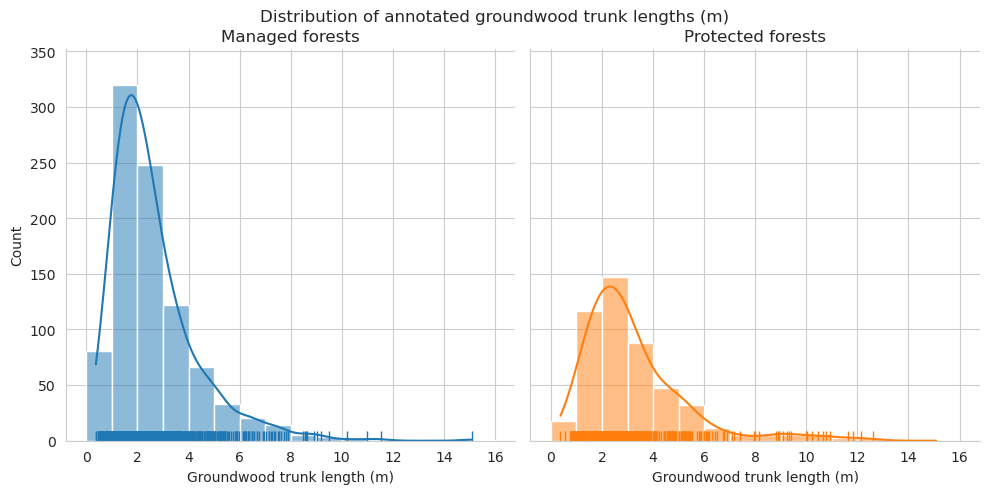

In [ ]:
#| echo: false
g = sns.displot(data=anns[anns.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(anns.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

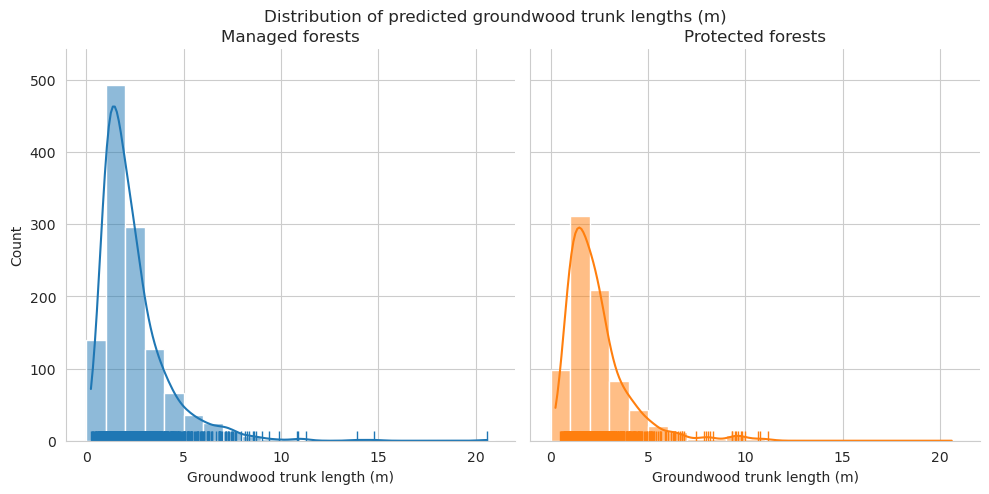

In [ ]:
#| echo: false
g = sns.displot(data=preds[preds.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(preds.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

Distributions for length look pretty similar, though there are some clear outliers in the predictions.

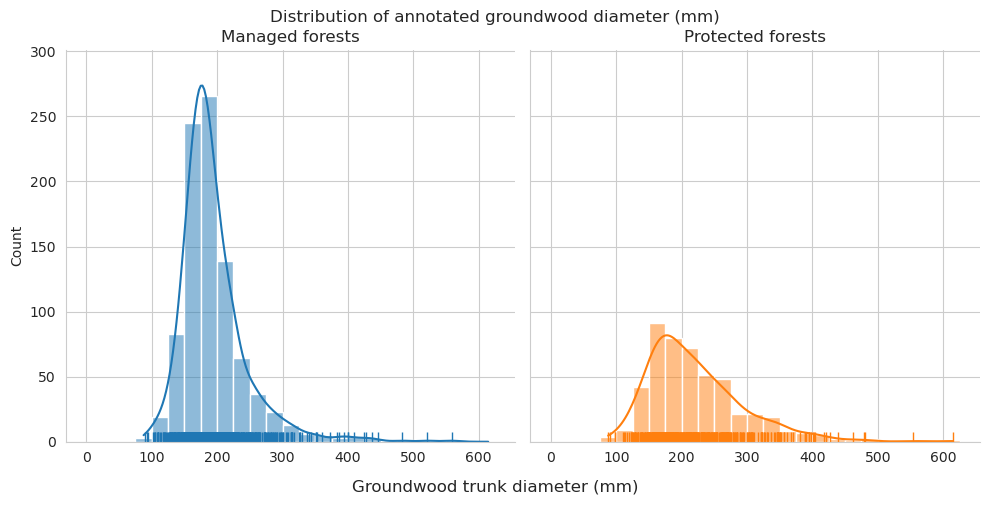

In [ ]:
#| echo: false
g = sns.displot(data=anns[(anns.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(anns[(anns.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

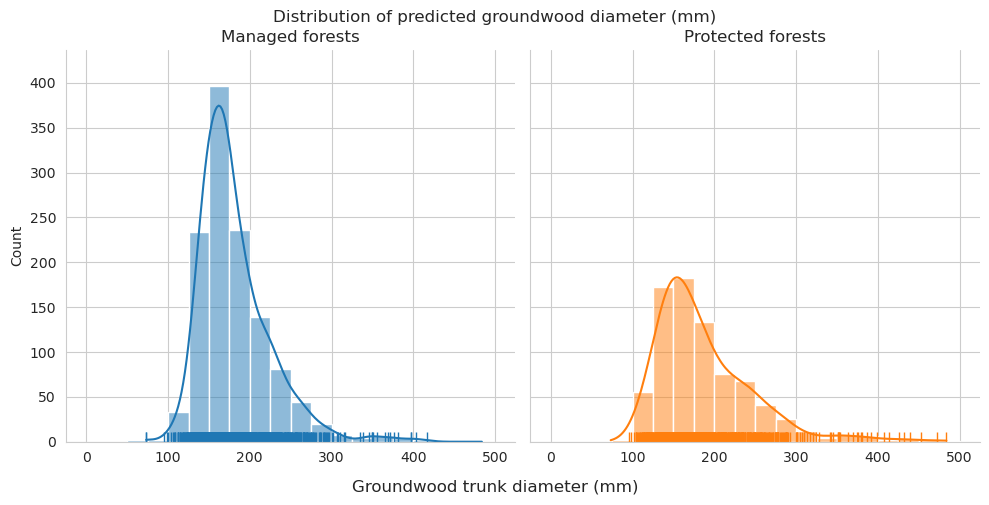

In [ ]:
#| echo: false
g = sns.displot(data=preds[(preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(preds[(preds.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

Diameter distributions differ mostly in the 150-175mm class, which is overrepresented for predictions in managed forests.

Check the statistics for diameter and length.

In [ ]:
anns[anns.layer=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                           margins=True, aggfunc=['mean', 'min', 'max'])

mean                    min                     max  \
                    diam tree_length       diam tree_length        diam   
conservation                                                              
0             194.449747    2.621222  89.906915    0.383440  558.643918   
1             220.942312    3.208590  87.563515    0.371857  614.556062   
All           203.620977    2.824558  87.563515    0.371857  614.556062   

                          
             tree_length  
conservation              
0              15.087245  
1              12.617573  
All            15.087245

In [ ]:
preds[preds.layer=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                           margins=True, aggfunc=['mean', 'min', 'max'])

mean                    min                     max  \
                    diam tree_length       diam tree_length        diam   
conservation                                                              
0             181.405153    2.390542  73.158266    0.234854  416.484903   
1             187.242699    2.351327  95.175610    0.472634  483.888458   
All           183.713359    2.375036  73.158266    0.234854  483.888458   

                          
             tree_length  
conservation              
0              20.598724  
1              11.152778  
All            20.598724

Check the area covered by standing deadwood canopies. First annotations.

In [ ]:
anns['area_m2'] = anns.geometry.area
preds['area_m2'] = preds.geometry.area
anns[anns.layer=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                            aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,3.066763,555.084039
1,4.061288,645.744719
All,3.531849,1200.828758


Then predictions. Predictions seem to slightly underestimate the sizes of standing deadwood canopies.

In [ ]:
preds[preds.layer=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                              aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,2.574031,960.113404
1,3.667250,700.444729
All,2.944252,1660.558133


Check the volume estimations.

In [ ]:
anns['v_ddw'] = anns.geometry.apply(cut_cone_volume)
preds['v_ddw'] = preds.geometry.apply(cut_cone_volume)
virtual_plot_grid['vplot_id'] = virtual_plot_grid.apply(lambda p: f'{p.id}_{p.level_1}', axis=1)

test_cons_areas = cons_hp.overlay(virtual_plot_grid[virtual_plot_grid.vplot_id.isin(preds.vplot_id.unique())])

test_vplot_area = virtual_plot_grid[virtual_plot_grid.vplot_id.isin(preds.vplot_id.unique())].area.sum()
test_cons_area = test_cons_areas.area.sum()
test_man_area = test_vplot_area - test_cons_area
test_man_ha = test_man_area / 10000
test_cons_ha = test_cons_area / 10000

ann_est_v_man = anns[(anns.layer=='groundwood')&(anns.conservation==0)].v_ddw.sum()/test_man_ha
ann_est_v_cons = anns[(anns.layer=='groundwood')&(anns.conservation==1)].v_ddw.sum()/test_cons_ha
ann_est_v_test = anns[(anns.layer=='groundwood')].v_ddw.sum()/(test_vplot_area/10000)

pred_est_v_man = preds[(preds.layer=='groundwood')&(preds.conservation==0)].v_ddw.sum()/test_man_ha
pred_est_v_cons = preds[(preds.layer=='groundwood')&(preds.conservation==1)].v_ddw.sum()/test_cons_ha
pred_est_v_test = preds[(preds.layer=='groundwood')].v_ddw.sum()/(test_vplot_area/10000)

In [ ]:
print(f'Estimated groundwood volume in managed forests, based on annotations: {ann_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on annotations: {ann_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on annotations: {ann_est_v_test:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on annotations: 13.05 ha/m³
Estimated groundwood volume in conserved forests, based on annotations: 14.05 ha/m³
Estimated groundwood volume in both types, based on annotations: 13.50 ha/m³


In [ ]:
print(f'Estimated groundwood volume in managed forests, based on predictions: {pred_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on predictions: {pred_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on predictions: {pred_est_v_test:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on predictions: 15.02 ha/m³
Estimated groundwood volume in conserved forests, based on predictions: 13.74 ha/m³
Estimated groundwood volume in both types, based on predictions: 14.43 ha/m³


## Predictions vs field data, with only predictions present in field plots

Count the number of annotated deadwood instances in each circular field plot, as well as note which of the circular plots are located in the conserved areas.

In [ ]:
plot_dw_data['n_dw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['n_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==2].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==2].plot_id.unique() else 0, axis=1)
plot_dw_data['n_udw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==1].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==1].plot_id.unique() else 0, axis=1)
plot_dw_data['geometry'] = plot_dw_data.apply(lambda row: plot_circles[plot_circles.id == row.id].geometry.iloc[0], 
                                              axis=1)
plot_dw_data = gpd.GeoDataFrame(plot_dw_data, crs=plot_circles.crs)
plot_dw_data['conservation'] = plot_dw_data.apply(lambda row: 1 if any(cons_hp.geometry.contains(row.geometry))
                                                  else 0, axis=1)
plot_dw_data['n_dw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['n_ddw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[preds_in_plots.label==2].plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots[preds_in_plots.label==2].plot_id.unique() else 0, axis=1)
plot_dw_data['n_udw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[preds_in_plots.label==1].plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots[preds_in_plots.label==1].plot_id.unique() else 0, axis=1)

Compare the numbers of annotations (`n_*_ann`), predictions (`n_*_pred`) and field measured (`n_*_plot`) deadwood instances.

In [ ]:
plot_dw_data.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 
                                                       'n_ddw_ann', 'n_udw_ann',
                                                       'n_ddw_pred', 'n_udw_pred'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_ddw_pred,n_udw_ann,n_udw_plot,n_udw_pred
conservation,,,,,,
0,44,48,57,13,12,15
1,11,47,22,4,8,3
All,55,95,79,17,20,18


Get plot-wise canopy cover percentage based on LiDAR derived canopy height model as the percentage of plot area with height more than 2 meters.

In [ ]:
pcts = []

with rio.open('../../data/raw/hiidenportti/full_mosaics/CHM_Hiidenportti_epsg.tif') as src:
    crs = src.crs
    for row in plot_dw_data.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])
plot_dw_data['canopy_cover_pct'] = pcts

Plot the relationship between annotated deadwood and field data.

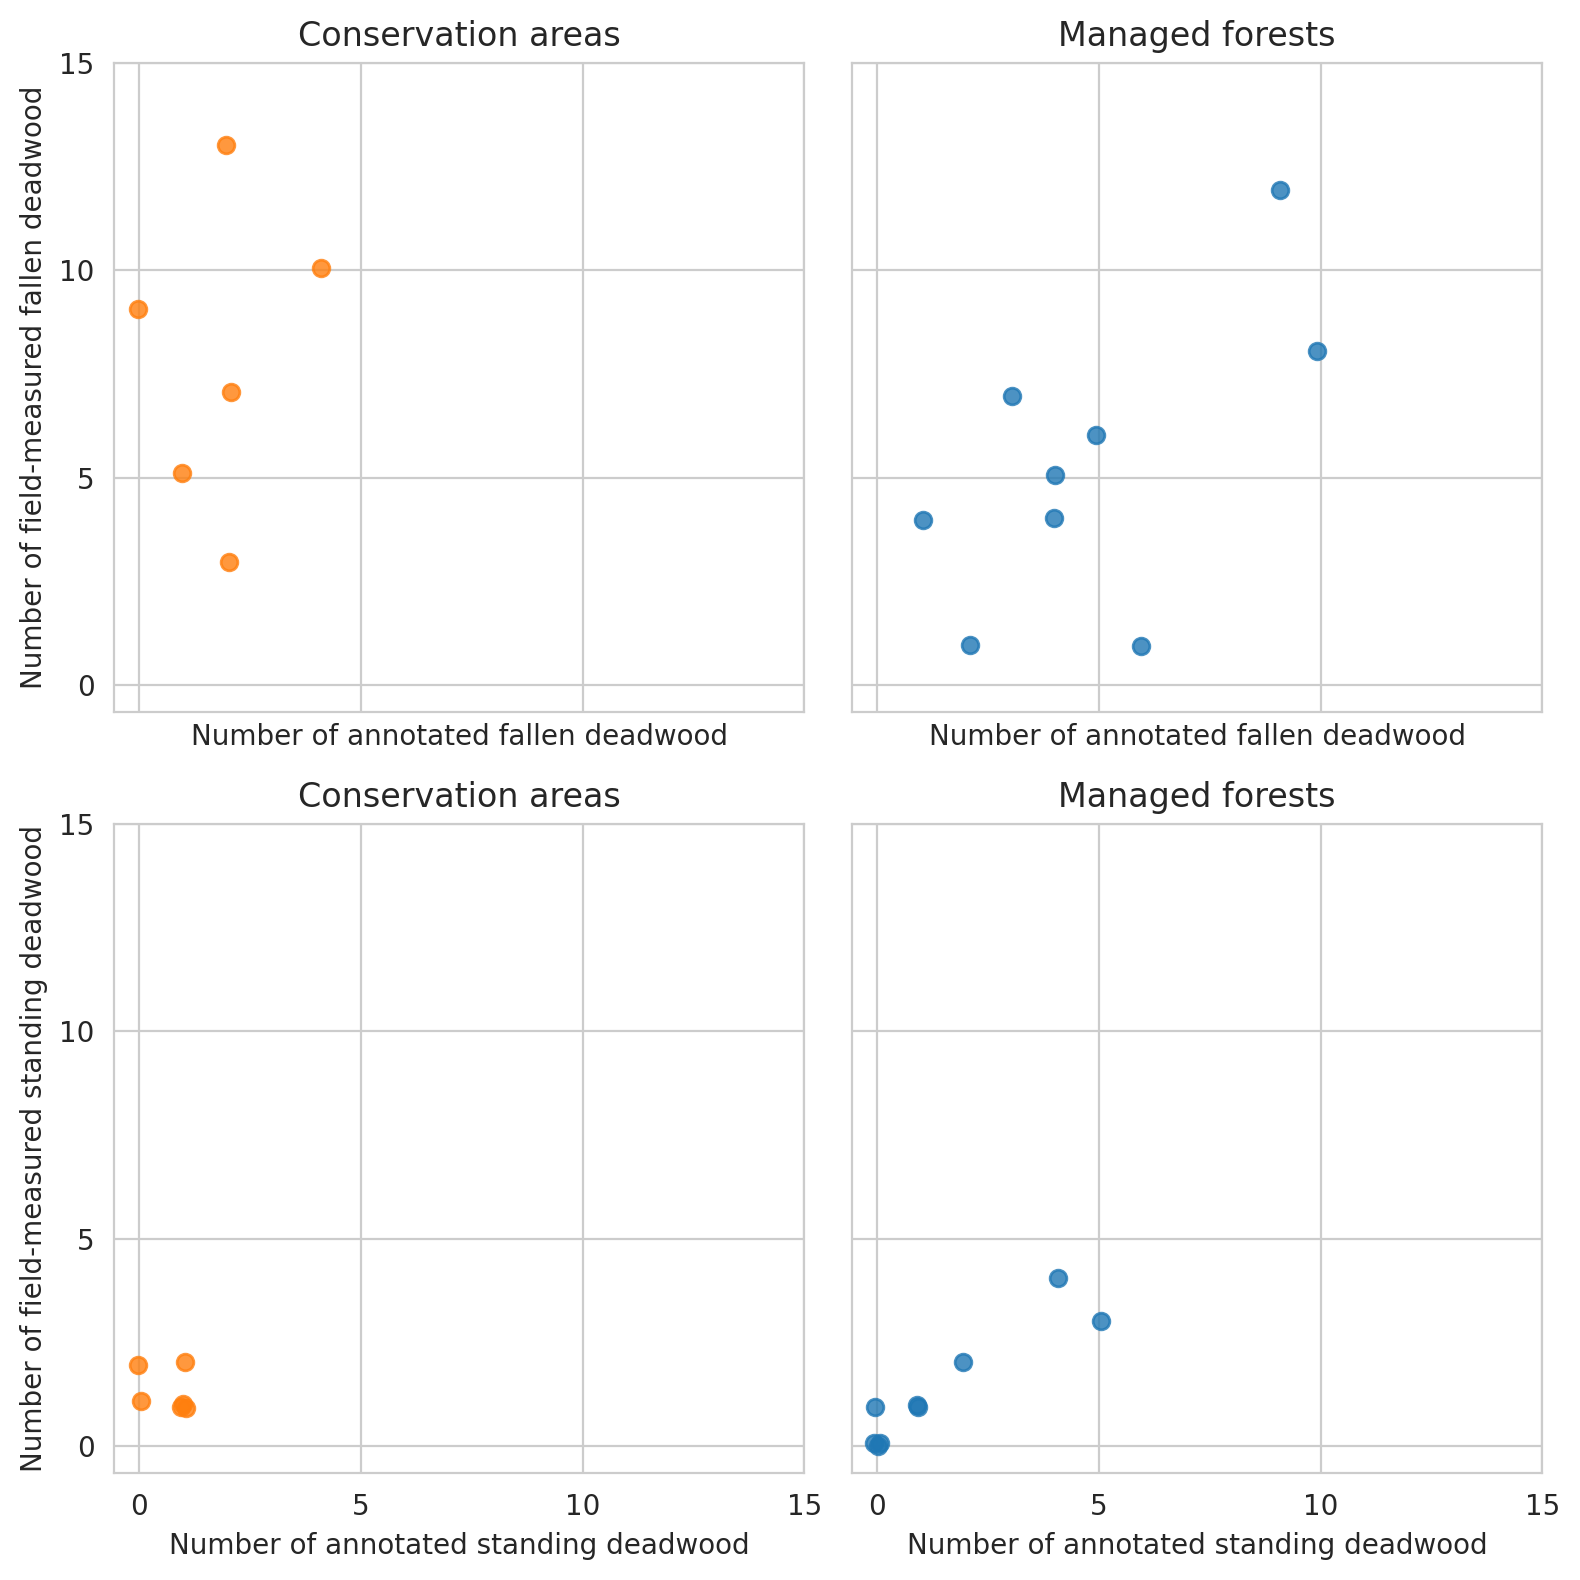

In [ ]:
#| echo: false
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,16,5))
ax[0,0].set_yticklabels(range(0,16,5))
ax[0,0].set_xticks(range(0,16,5))
ax[0,0].set_xticklabels(range(0,16,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,16,5))
ax[0,1].set_yticklabels(range(0,16,5))
ax[0,1].set_xticks(range(0,16,5))
ax[0,1].set_xticklabels(range(0,16,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,16,5))
ax[1,0].set_yticklabels(range(0,16,5))
ax[1,0].set_yticks(range(0,16,5))
ax[1,0].set_yticklabels(range(0,16,5))
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,16,5))
ax[1,1].set_yticklabels(range(0,16,5))
ax[1,1].set_xticks(range(0,16,5))
ax[1,1].set_xticklabels(range(0,16,5))
plt.tight_layout()
plt.show()

Same for field data and predictions

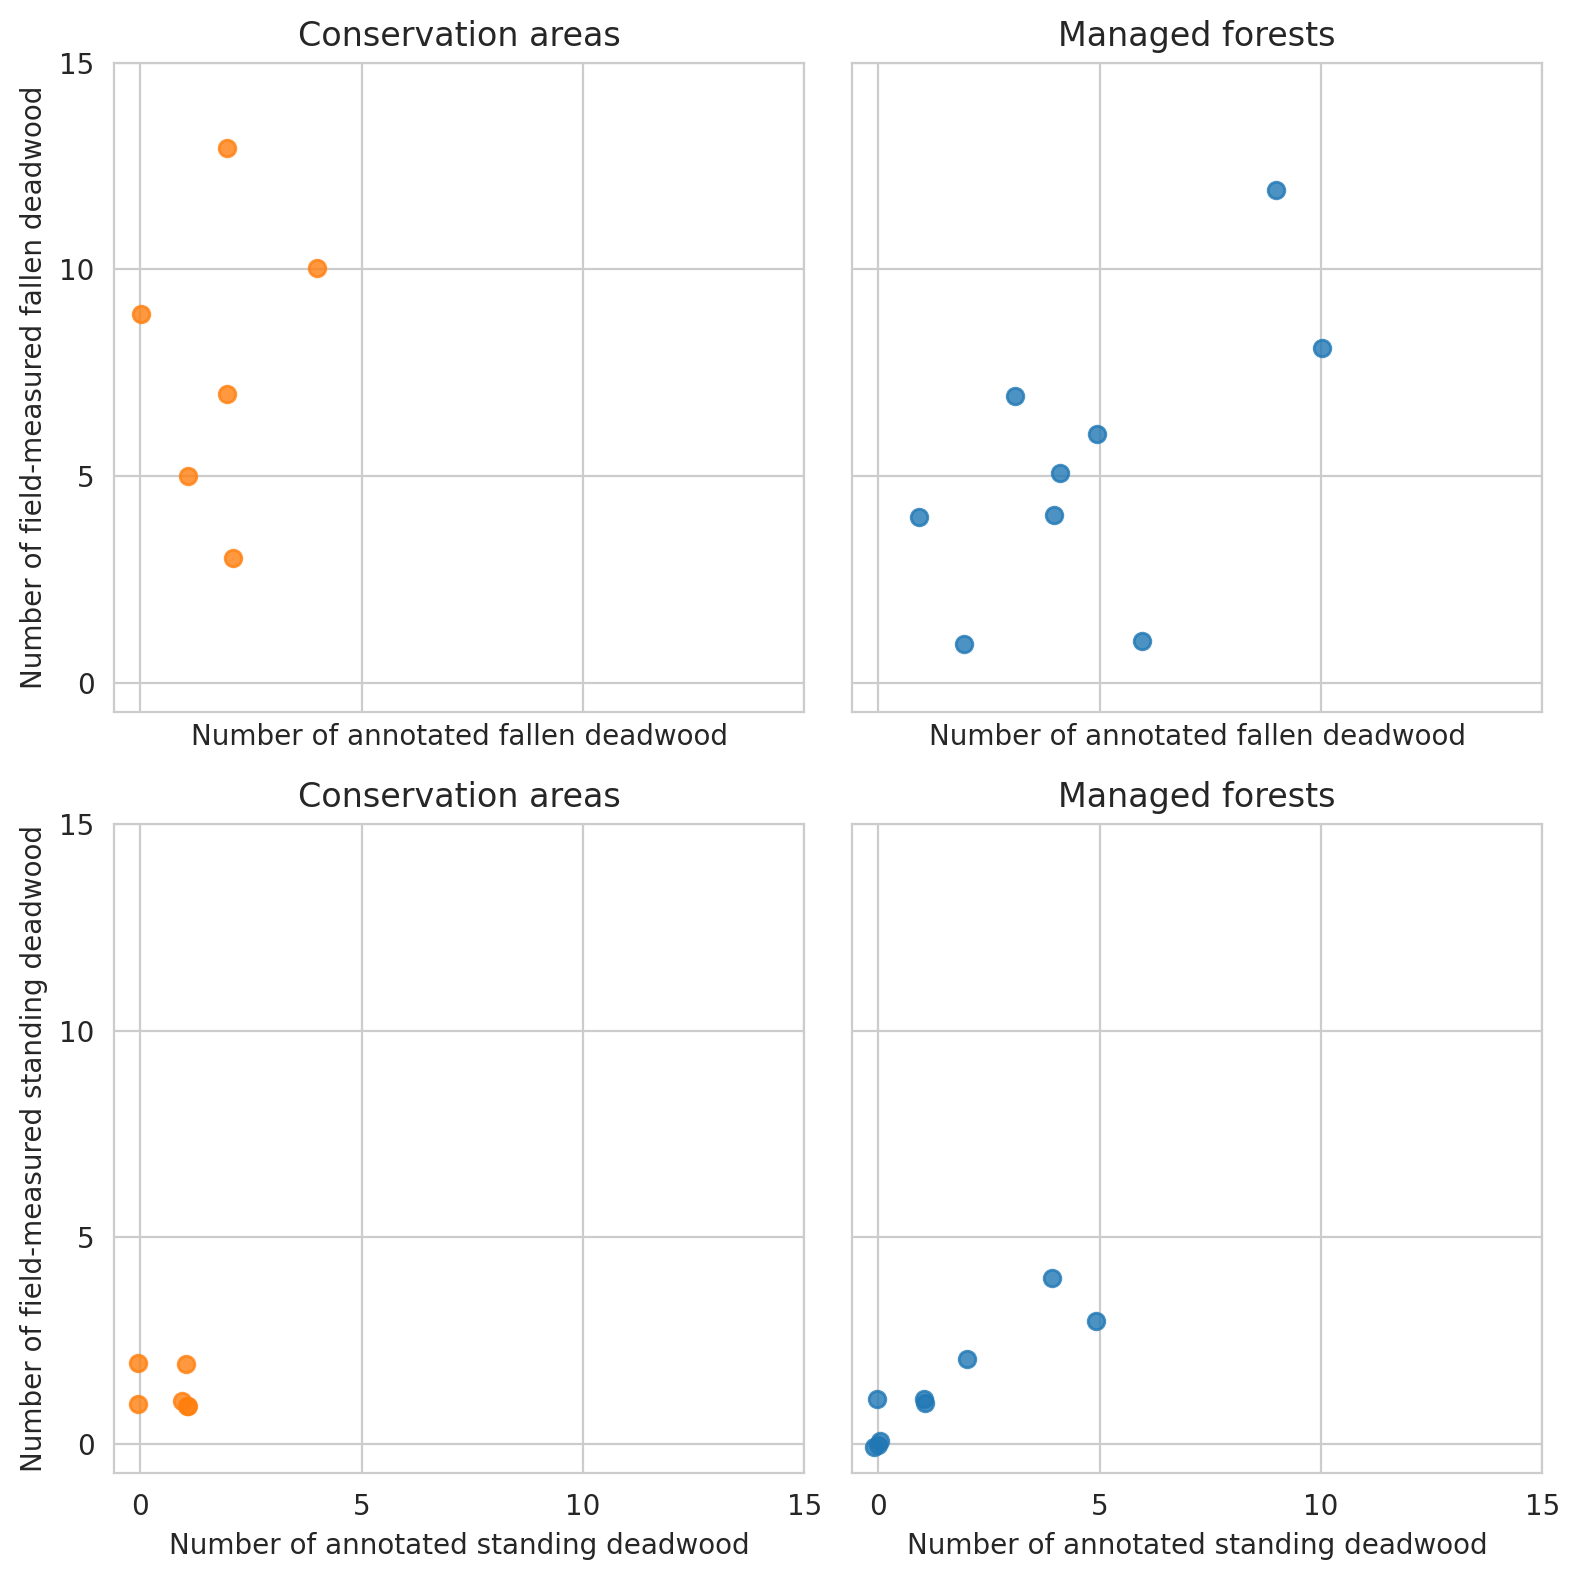

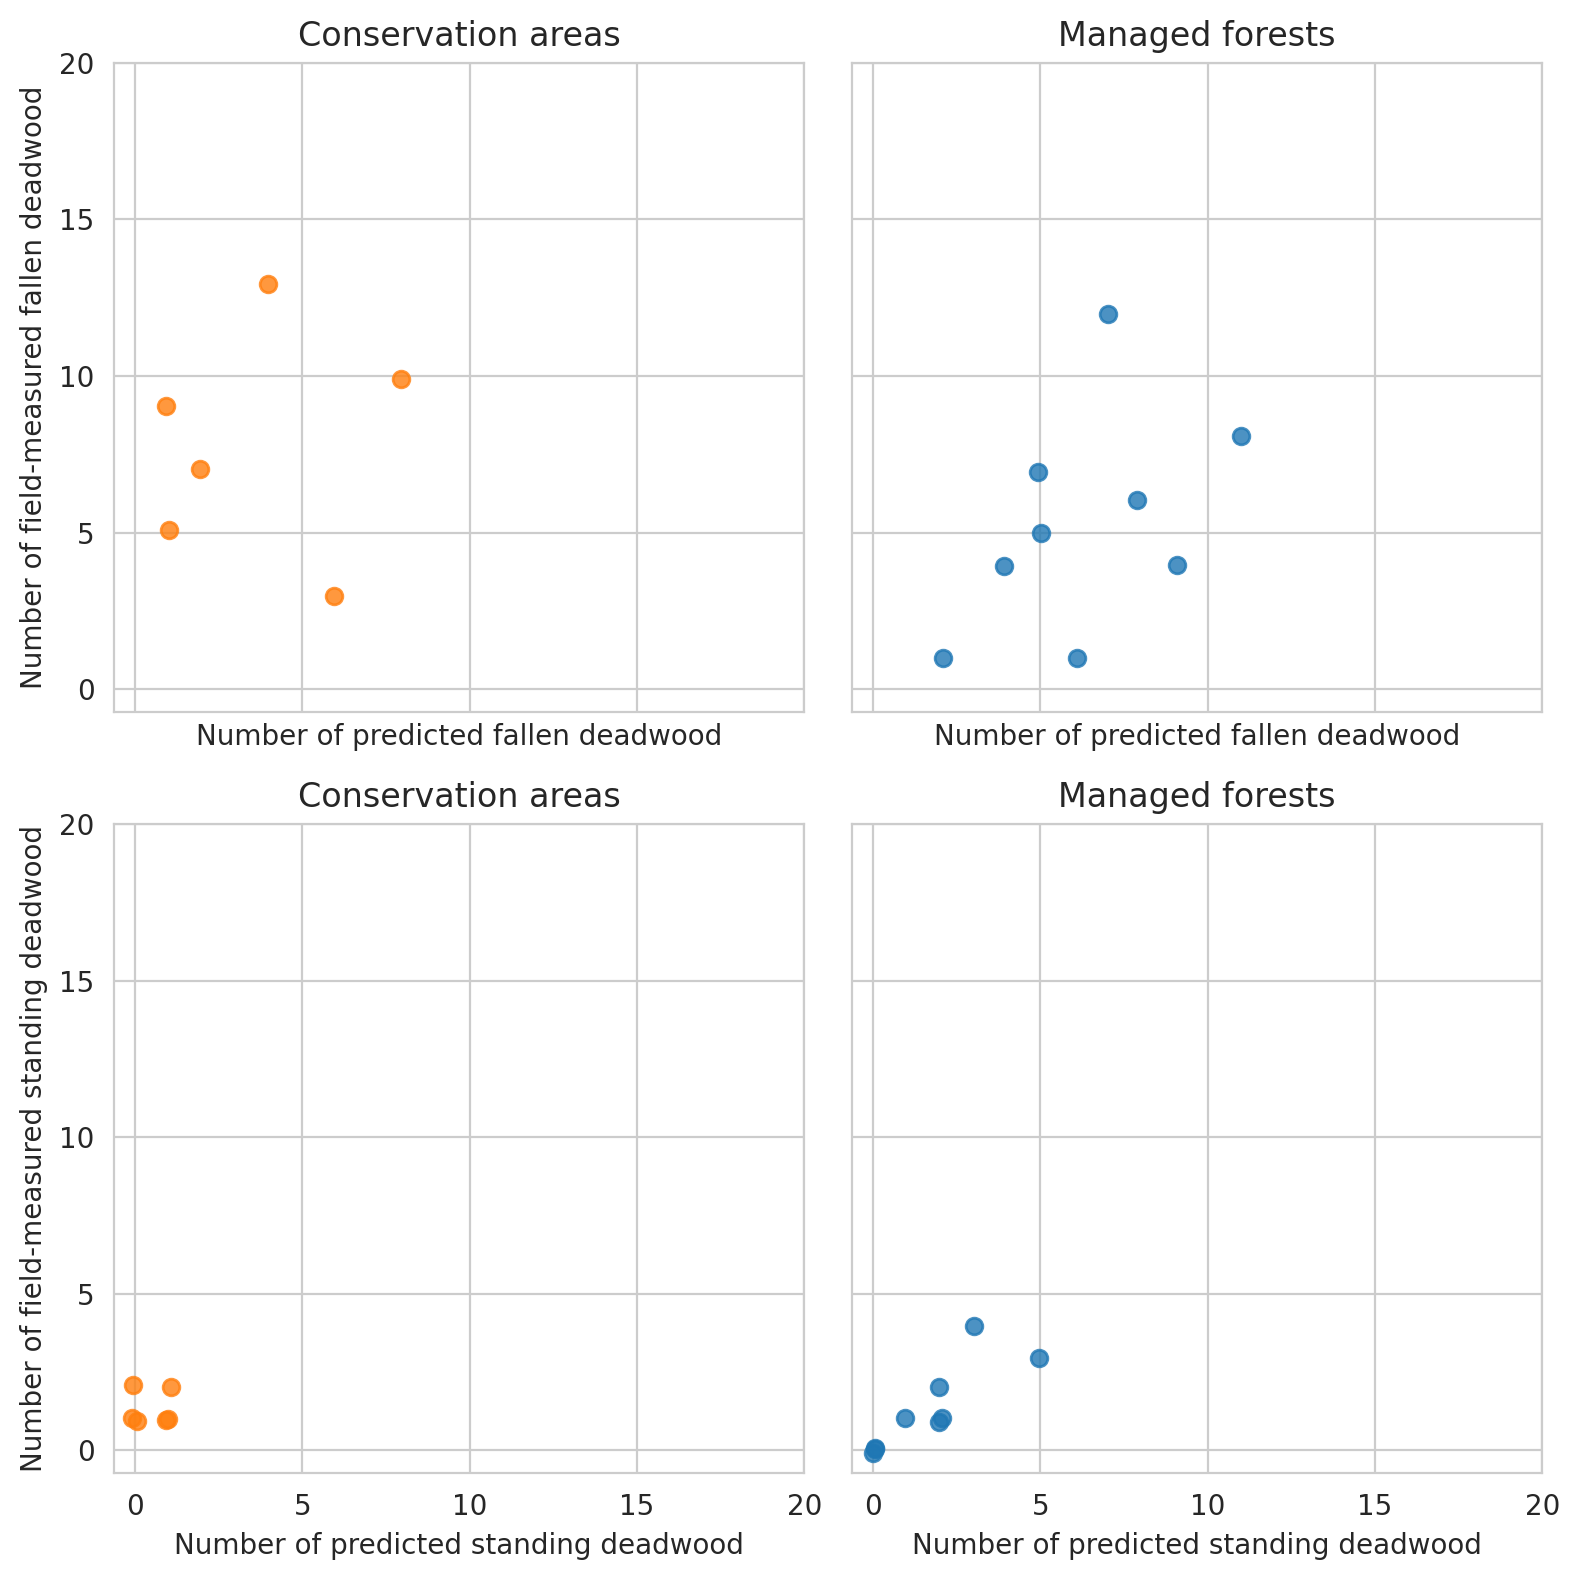

In [ ]:
#| echo: false

fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xticks(range(0,21,5))
ax[0,0].set_xticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of predicted fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xticks(range(0,21,5))
ax[0,1].set_xticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of predicted fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of predicted standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
ax[1,0].set_xticks(range(0,21,5))
ax[1,0].set_xticklabels(range(0,21,5))
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of predicted standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
ax[1,1].set_xticks(range(0,21,5))
ax[1,1].set_xticklabels(range(0,21,5))
plt.tight_layout()
plt.show()

Next the relationship between canopy cover and types of detected deadwood.

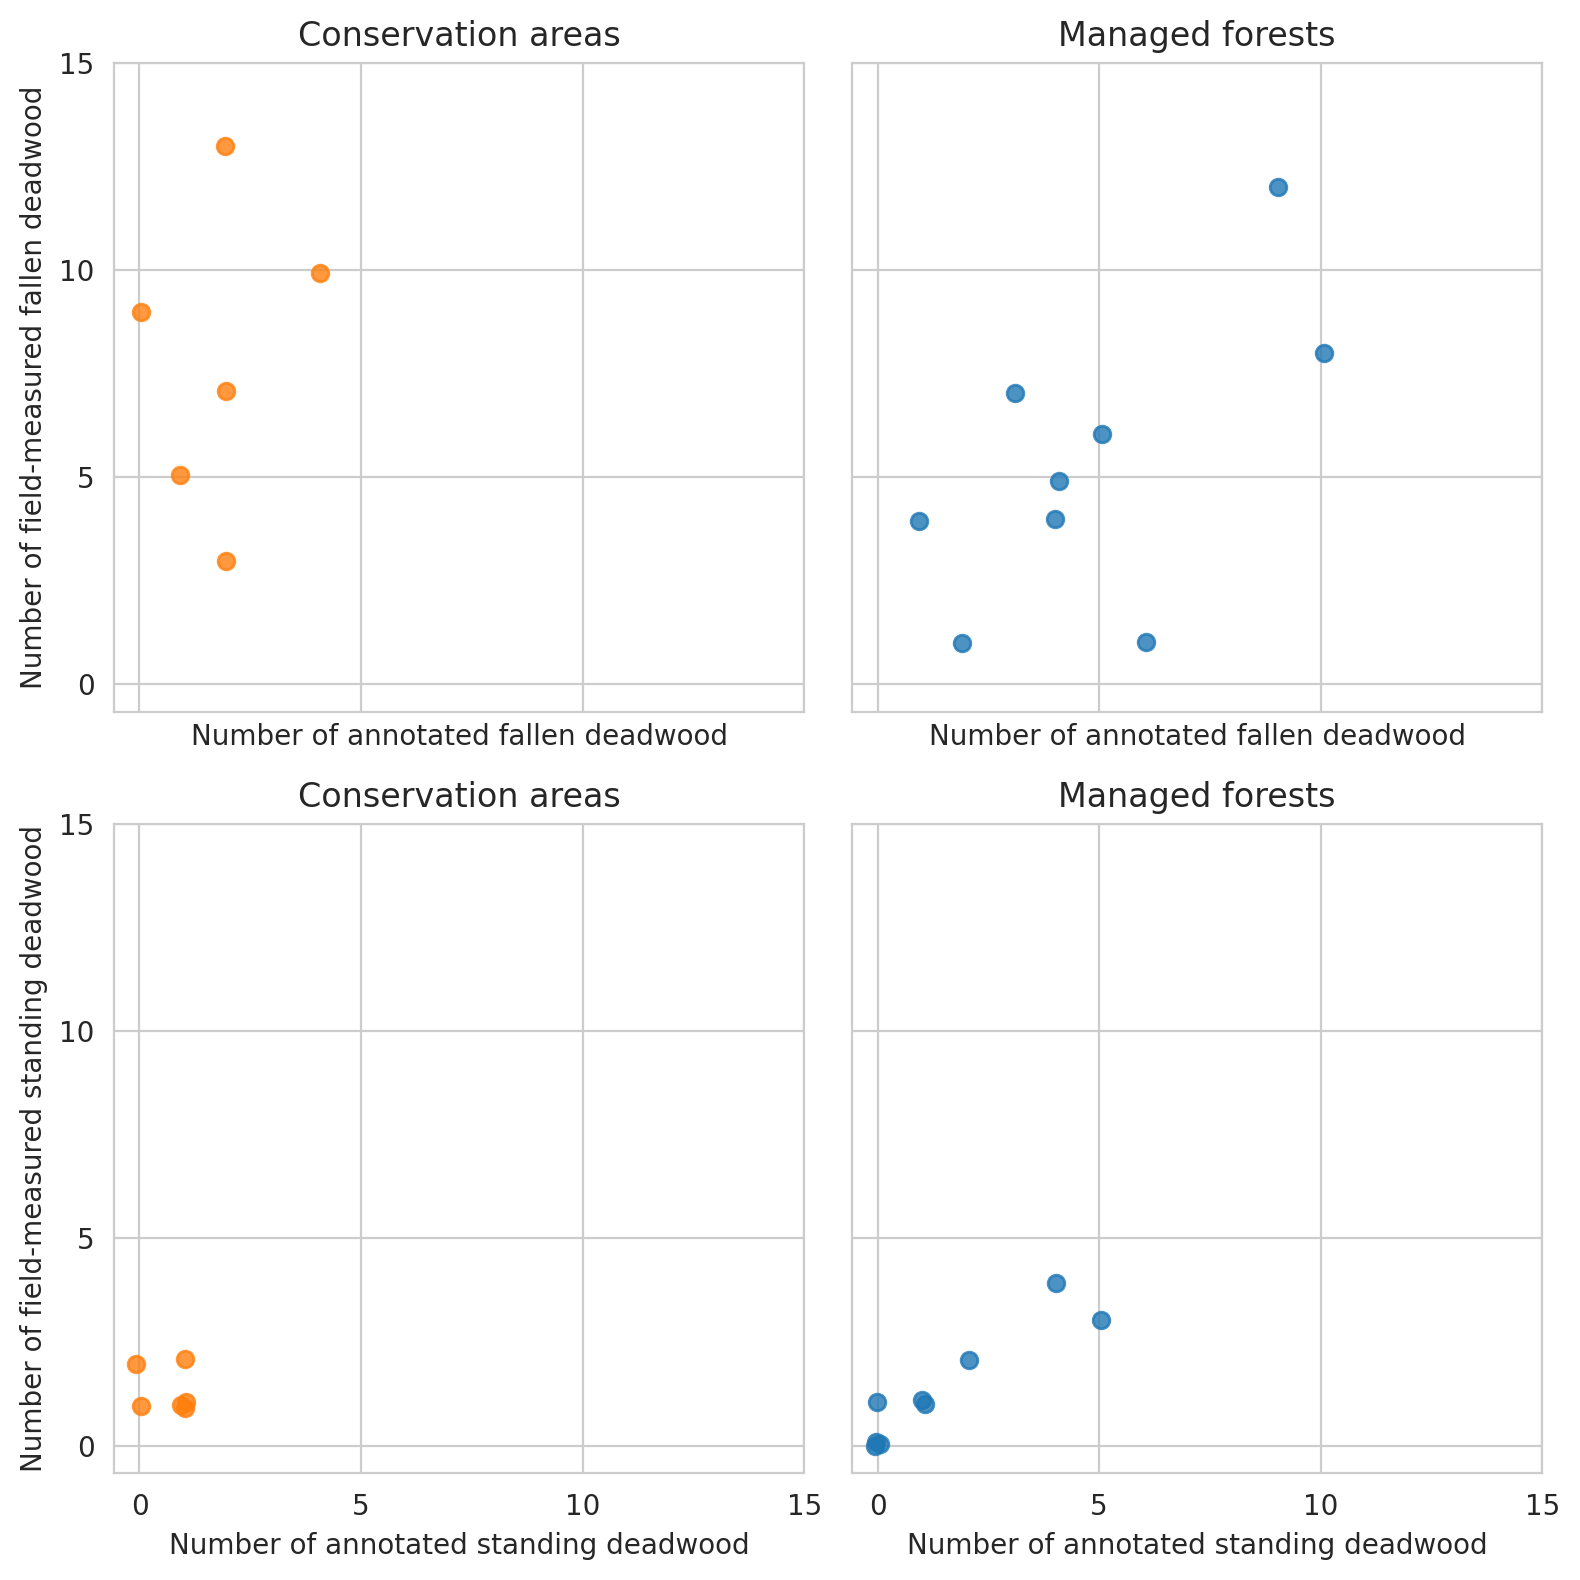

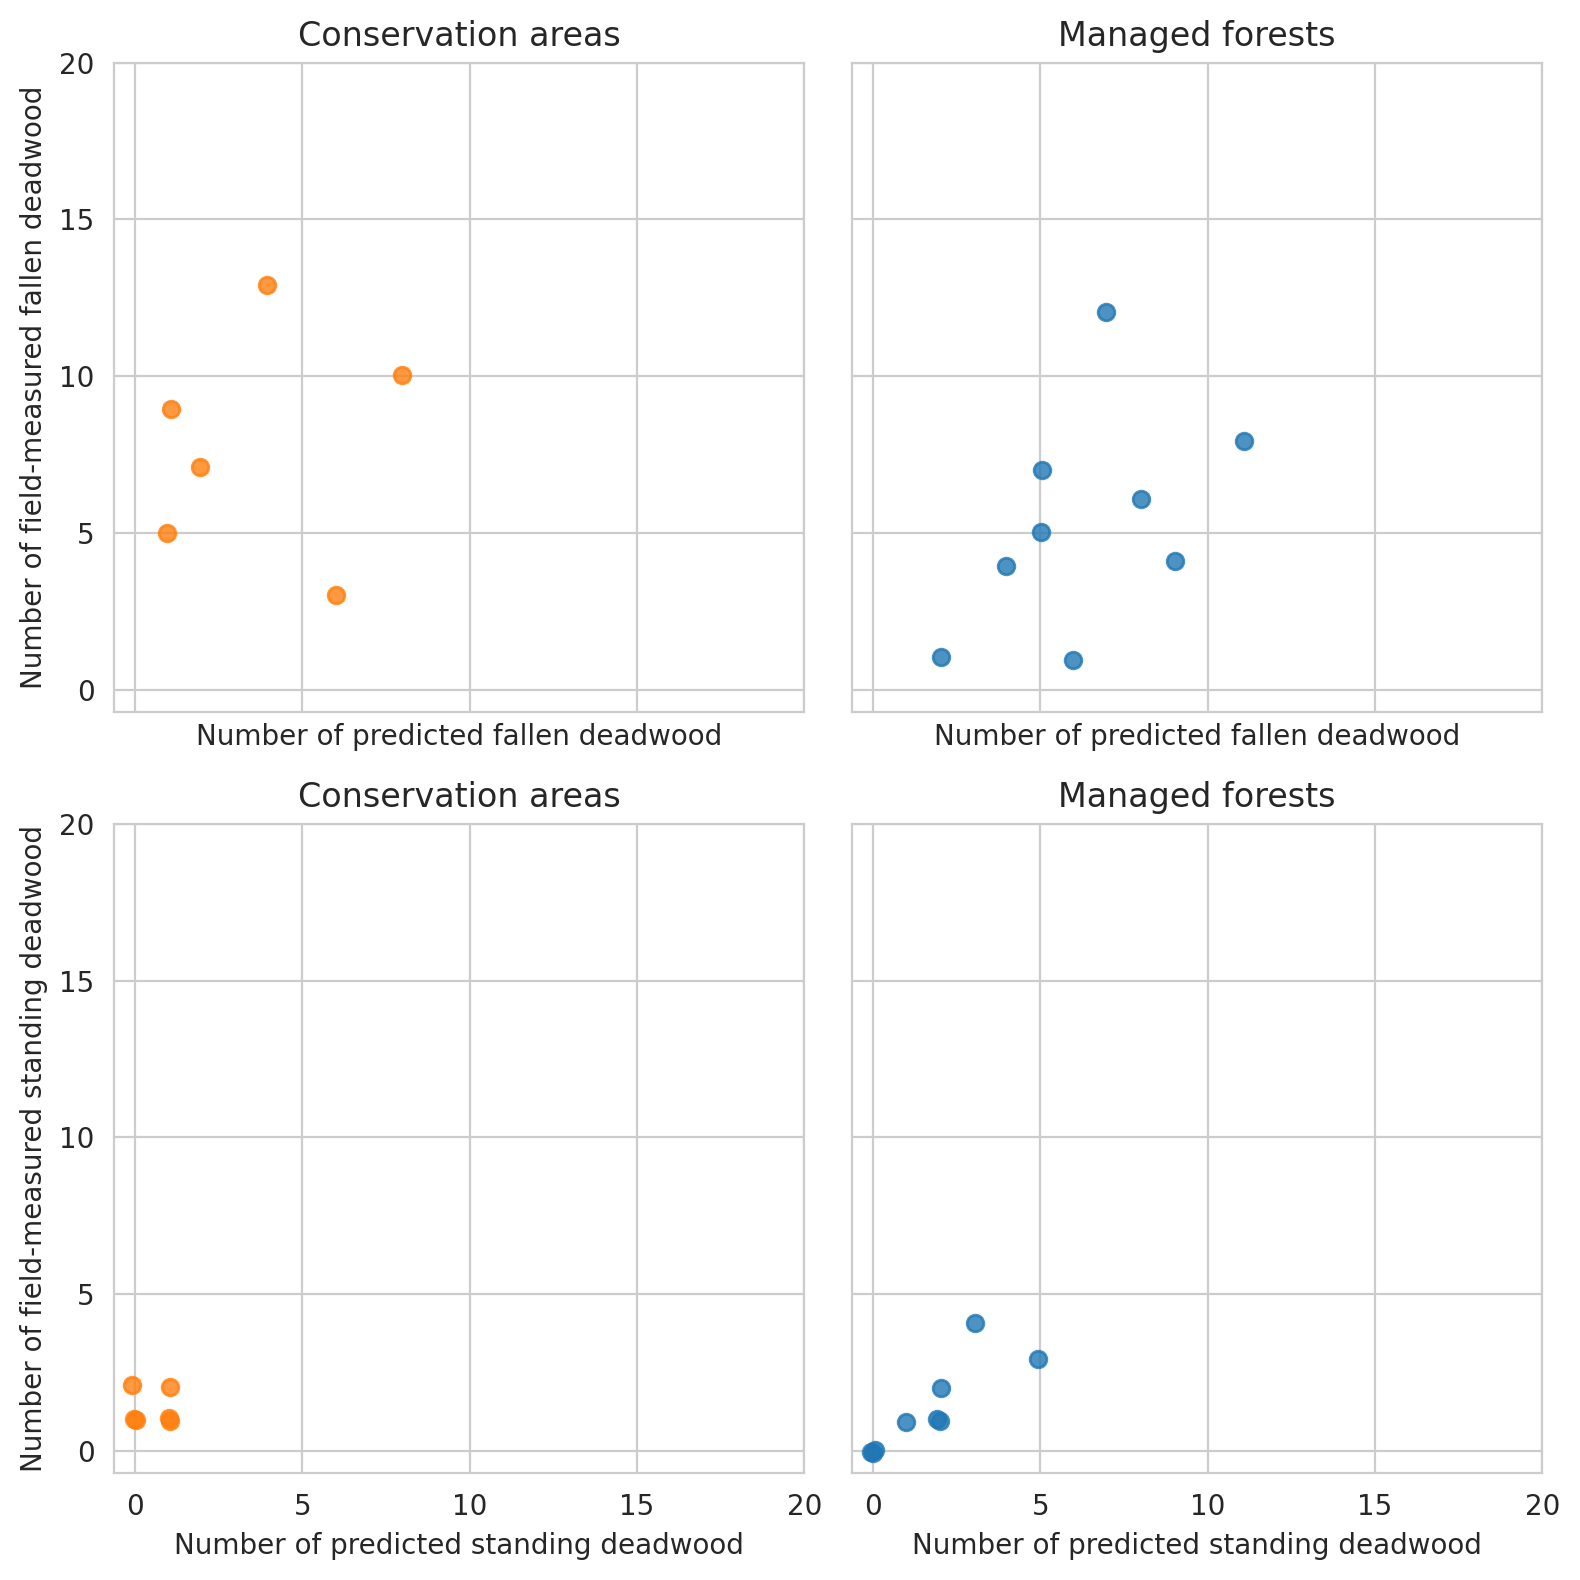

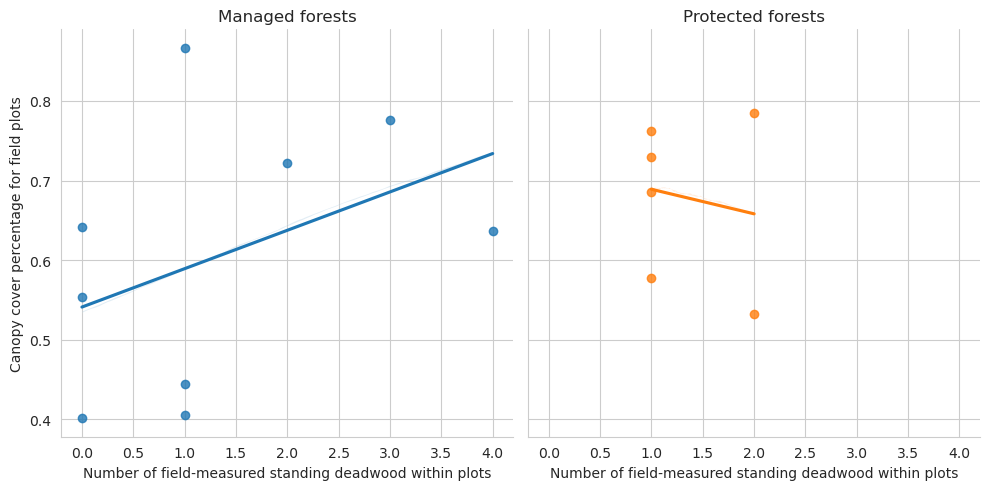

In [ ]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_plot', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of field-measured standing deadwood within plots')
plt.show()

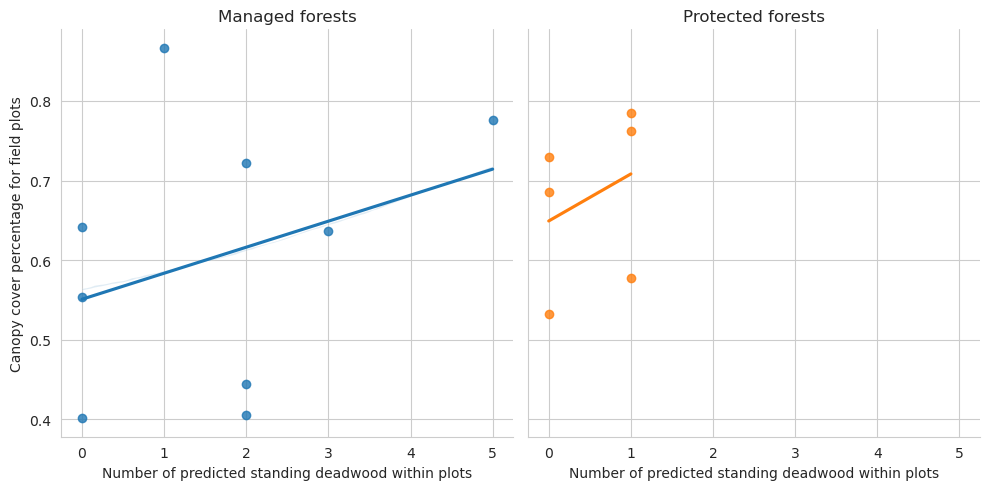

In [ ]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_pred', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of predicted standing deadwood within plots')
plt.show()

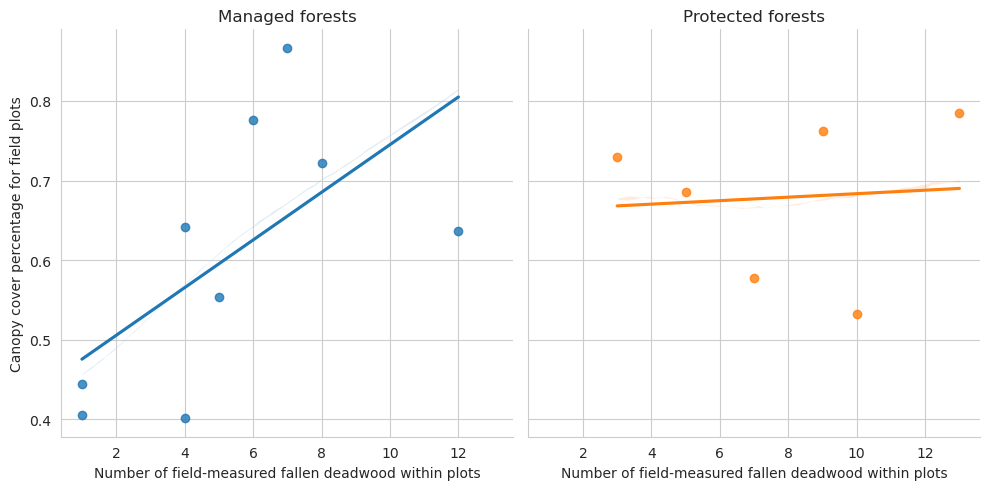

In [ ]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_plot', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of field-measured fallen deadwood within plots')
plt.show()

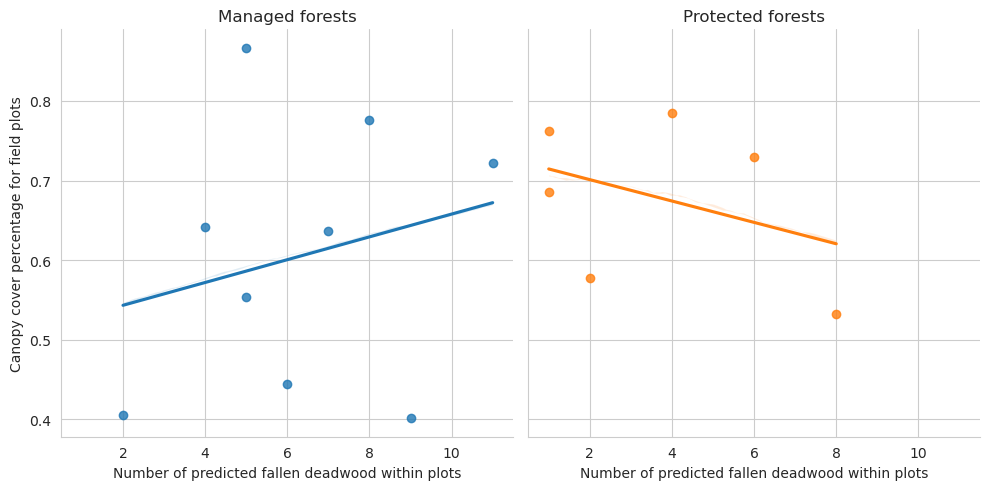

In [ ]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_pred', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of predicted fallen deadwood within plots')
plt.show()

Note that for the test set there are too few plots to draw meaningful conclusions.

Read individual tree measurements, and convert `l` from decimeters to meters.

In [ ]:
tree_data = pd.read_csv(field_data_path/'hiidenportti_singletree.csv')
tree_data = tree_data[tree_data.plot_id.isin(plot_dw_data.id.unique())]
tree_data['l'] /= 10

Add information about conservation area to tree data.

In [ ]:
tree_data['conservation'] = tree_data.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)
preds_in_plots['conservation'] = preds_in_plots.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)
anns_in_plots['tree_length'] = anns_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)
preds_in_plots['tree_length'] = preds_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)

Compare the distributions of the downed trunk lengths. Both graphs only take the parts within the plots into account. Lengths are binned into 1m bins.

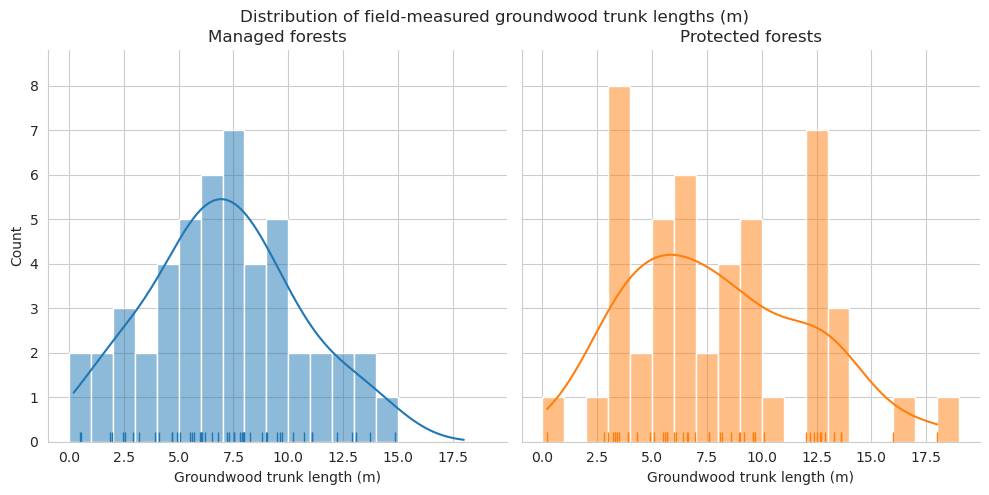

In [ ]:
#| echo: false
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.l > 0)], x='l', 
                hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=1, binrange=(0, max(tree_data[tree_data.tree_class == 4].l))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

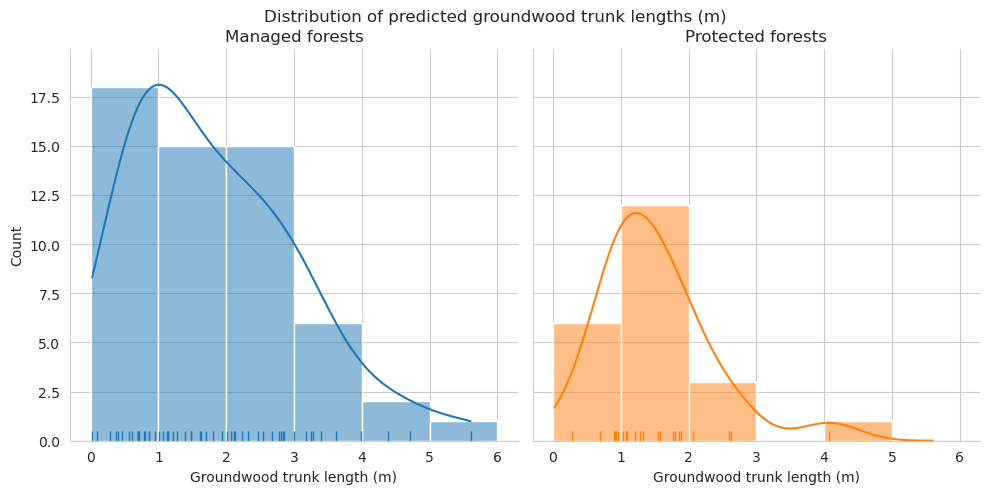

In [ ]:
#| echo: false

g = sns.displot(data=preds_in_plots[preds_in_plots.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(preds_in_plots.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

As expected, annotated trunks are clearly on average shorter than field measured.

Compare the measured DBH for downed trees and estimated diameter of annotated downed deadwood. For annotated deadwood, the diameter is estimated for the whole tree, not only for the part within the field plot. DBHs are binned into 50mm bins.

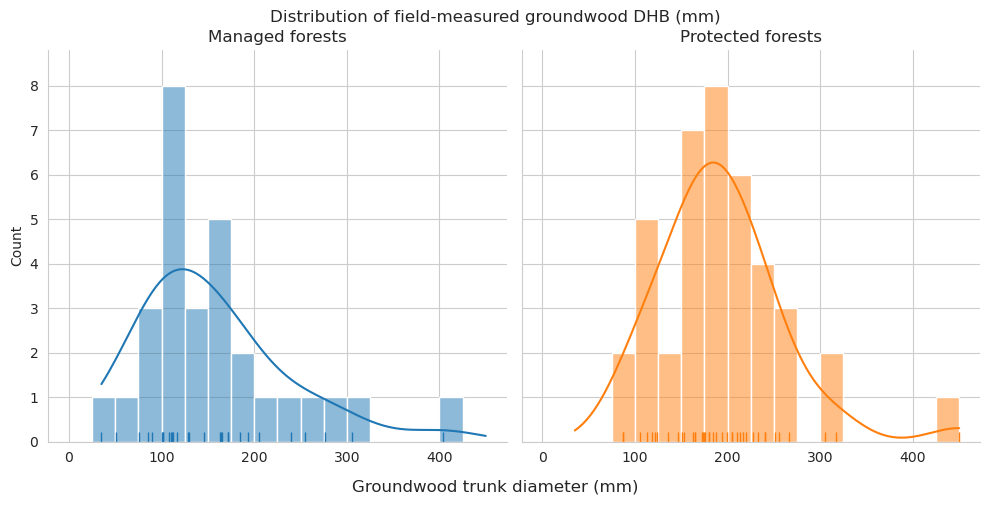

In [ ]:
#| echo: false

g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)], x='dbh', hue='conservation', 
                col='conservation', kde=True, rug=True, legend=False, binwidth=25,
                binrange=(0, max(tree_data[(tree_data.tree_class == 4)].dbh))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

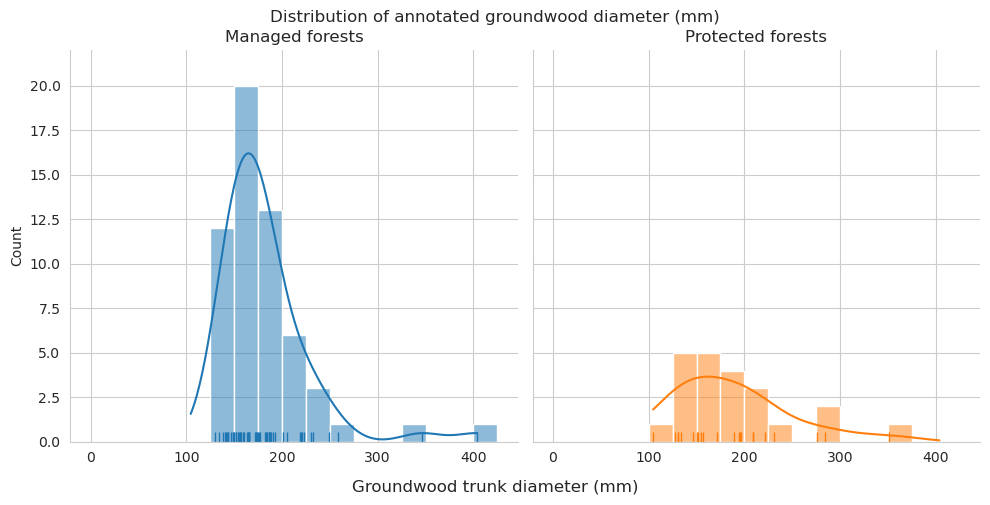

In [ ]:
#| echo: false

preds_in_plots['diam'] = preds_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=preds_in_plots[(preds_in_plots.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(preds_in_plots[(preds_in_plots.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

See the statistics for groundwood length and diameter. First for field data.

In [ ]:
pd.pivot_table(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)],
               index=['conservation'], values=['l', 'dbh'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean           min            max         
                     dbh         l dbh         l  dbh        l
conservation                                                  
0             155.275862  8.124393  35  1.866795  404  13.7169
1             192.725000  7.360910  87  2.792713  450  16.0000
All           176.985507  7.681794  35  1.866795  450  16.0000

Then for predictions.

In [ ]:
pd.pivot_table(data=preds_in_plots[preds_in_plots.label==2], index=['conservation'], values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             182.033767    1.825179  129.573492    0.023569  403.833659   
1             186.961887    1.524233  104.611167    0.285395  350.669633   
All           183.406155    1.741371  104.611167    0.023569  403.833659   

                          
             tree_length  
conservation              
0               5.605036  
1               4.077773  
All             5.605036

Then compare the statistics for volume estimations, first for field data.

In [ ]:
anns_in_plots.head()

,layer,groundwood,annotator,vplot_id,conservation,area,pixel_area,tree_length,diam,v,geometry,plot_id
1411,groundwood,2,Max,104_28,1,0.644751,402.969683,1.594323,212.359402,0.105259,"POLYGON ((604150.513 7085232.790, 604150.549 7...",1021
1453,groundwood,2,Max,104_28,1,1.414625,884.140741,4.080575,345.111283,0.370154,"POLYGON ((604181.257 7085246.100, 604181.383 7...",106
1454,groundwood,2,Max,104_28,1,0.519736,324.835065,1.823714,168.601269,0.069253,"POLYGON ((604177.716 7085250.649, 604177.716 7...",106
1495,groundwood,2,Max,104_28,1,0.939413,587.133423,1.595601,211.020673,0.170170,"POLYGON ((604252.091 7085292.120, 604252.532 7...",3
1508,groundwood,2,Max,104_28,1,2.754999,1721.874647,2.942067,295.731871,0.638758,"POLYGON ((604283.877 7085273.930, 604283.877 7...",2


In [ ]:
anns_in_plots['v_ddw'] = anns_in_plots.geometry.apply(cut_cone_volume)

plot_dw_data['v_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                        (anns_in_plots.layer == 'groundwood')
                                                                       ].v_ddw.sum()
                                              , axis=1)
preds_in_plots['v_ddw'] = preds_in_plots.geometry.apply(cut_cone_volume)
plot_dw_data['v_ddw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[(preds_in_plots.plot_id == row.id) &
                                                                        (preds_in_plots.layer == 'groundwood')
                                                                       ].v_ddw.sum()
                                              , axis=1)
plot_dw_data['v_dw_plot'] = (plot_dw_data['v_dw']/10000)*np.pi*9**2
plot_dw_data['v_ddw_plot'] = (plot_dw_data['v_ddw']/10000)*np.pi*9**2
plot_dw_data['v_udw_plot'] = plot_dw_data.v_dw_plot - plot_dw_data.v_ddw_plot
pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,1.476682,88.948335,29.528714,22.513292,28.686318,9
1,65.155283,139.171786,82.494768,71.816212,28.298432,6
All,1.476682,139.171786,50.715136,48.100161,38.439837,15


Then for predictions.

In [ ]:
plot_dw_data['v_ddw_pred_ha'] = (10000 * plot_dw_data.v_ddw_pred) / (np.pi * 9**2)

pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw_pred_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha
conservation,,,,,,
0,6.625440,72.586855,25.363117,13.974665,23.835000,9
1,0.577543,31.267999,11.100231,7.831228,11.880831,6
All,0.577543,72.586855,19.657963,12.888527,20.672577,15


Based on these plots, our predictions clearly underestimate the total volume of fallen deadwood, especially in conserved forests.

# Sudenpesänkangas

Read data and do some wrangling.

In [ ]:
evo_fd_path = Path('../data/sudenpesankangas/')
evo_anns = gpd.read_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')
evo_anns = evo_anns.to_crs('epsg:3067')
evo_preds = gpd.read_file('../results/sudenpesankangas/spk_merged_20220825.geojson')
evo_plot_circles = gpd.read_file(evo_fd_path/'plot_circles.geojson')
evo_plot_circles['id'] = evo_plot_circles['id'].astype(int)
evo_field_data = pd.read_csv(evo_fd_path/'puutiedot_sudenpesänkangas.csv', sep=';', decimal=',')
evo_field_data = gpd.GeoDataFrame(evo_field_data, geometry=gpd.points_from_xy(evo_field_data.gx, evo_field_data.gy), 
                                   crs='epsg:3067')
evo_grid = gpd.read_file(evo_fd_path/'vplots.geojson')
evo_grid = evo_grid.to_crs('epsg:3067')
evo_field_data['plotid'] = evo_field_data.kaid + 1000
evo_field_data = evo_field_data[evo_field_data.puuluo.isin([3,4])]

cons_evo = conservation_areas[conservation_areas.geometry.intersects(box(*evo_anns.total_bounds))]
cons_evo = gpd.clip(cons_evo, evo_grid)

def match_plotid_spk(geom, plots):
    for r in plots.itertuples():
        if r.geometry.intersects(geom):
            return r.id
    return None

def match_vplot_spk(geom, plots):
    for p in plots.itertuples():
        if geom.intersects(p.geometry):
            return f'{p.fid}_{int(p.id)}'

Get up-to-date field data

In [ ]:
evo_plots_updated = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018.txt', sep=' ')
evo_plots_luke = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018_LUKE.txt', sep=' ')
evo_plots_updated = gpd.GeoDataFrame(evo_plots_updated, geometry=gpd.points_from_xy(evo_plots_updated.x,
                                                                                    evo_plots_updated.y),
                                     crs='epsg:3067')
evo_plots_luke = gpd.GeoDataFrame(evo_plots_luke, geometry=gpd.points_from_xy(evo_plots_luke.x,
                                                                              evo_plots_luke.y),
                                     crs='epsg:3067')
evo_plots = pd.concat([evo_plots_updated, evo_plots_luke])
evo_plots.rename(columns= {c: c.replace('.','_') for c in evo_plots.columns}, inplace=True)

evo_plots['spk_id'] = evo_plots.geometry.apply(lambda row: match_plotid_spk(row, evo_plot_circles))

evo_plots.dropna(subset='spk_id', inplace=True)

evo_plots['geometry'] = evo_plots.spk_id.apply(lambda row: evo_plot_circles[evo_plot_circles.id == row].geometry.iloc[0])

evo_plots.drop(columns=['id'], inplace=True)
evo_plots.rename(columns={'spk_id': 'id'}, inplace=True)

evo_plots['conservation'] = evo_plots.geometry.apply(lambda row: 1 if cons_evo.geometry.unary_union.intersects(row)
                                                     else 0)

evo_anns['plot_id'] = evo_anns.apply(lambda row: int(row.vplot_id.split('_')[1]), axis=1)

evo_plots = evo_plots[evo_plots.id.isin(evo_anns.plot_id.unique())]

evo_anns['plot_id'] = evo_anns.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_anns_in_plots = evo_anns[evo_anns.geometry.intersects(evo_plots.geometry.unary_union)].copy()

evo_preds['conservation'] = evo_preds.geometry.apply(lambda row: 1 if any(cons_evo.geometry.contains(row))
                                                         else 0)

evo_preds['vplot_id'] = evo_preds.geometry.apply(lambda row: match_vplot_spk(row, evo_grid))
evo_preds['plot_id'] = evo_preds.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_preds_in_plots = evo_preds[evo_preds.geometry.intersects(evo_plots.geometry.unary_union)].copy()
evo_preds_in_plots['plot_id'] = evo_preds_in_plots.plot_id.astype(int)

## Predictions vs annotations, all available data

Compare the numbers, first annotations.

In [ ]:
pd.crosstab(evo_anns.conservation, evo_anns.label, margins=True)

label,groundwood,uprightwood,All
conservation,,,
0,2369,386,2755
1,1546,1033,2579
All,3915,1419,5334


Then predictions.

In [ ]:
pd.crosstab(evo_preds.conservation, evo_preds.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,2437,383,2820
1,1693,807,2500
All,4130,1190,5320


Add lenght and diameter information to groundwood.

In [ ]:
evo_anns['tree_length'] = evo_anns.geometry.apply(get_len)
evo_preds['tree_length'] = evo_preds.geometry.apply(get_len)
evo_anns['diam'] = evo_anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
evo_preds['diam'] = evo_preds.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000

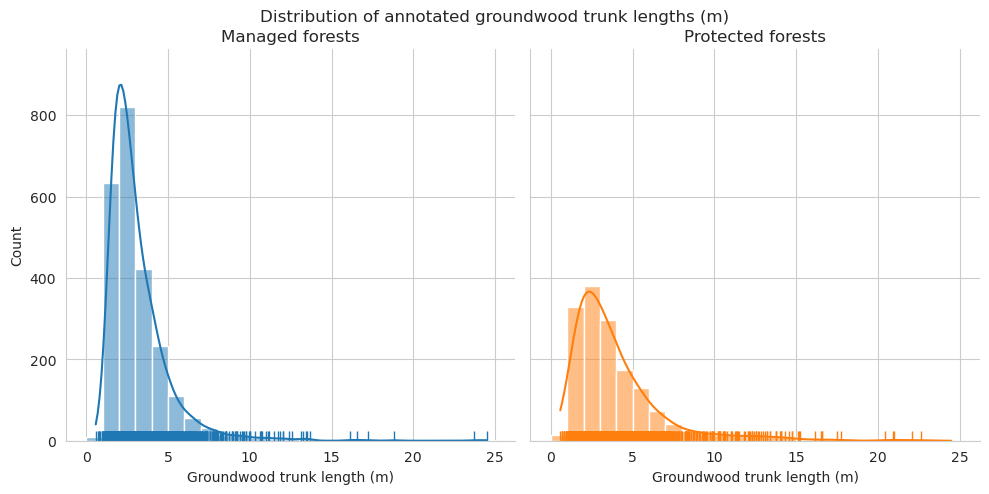

In [ ]:
#| echo: false
g = sns.displot(data=evo_anns[evo_anns.label=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(evo_anns.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

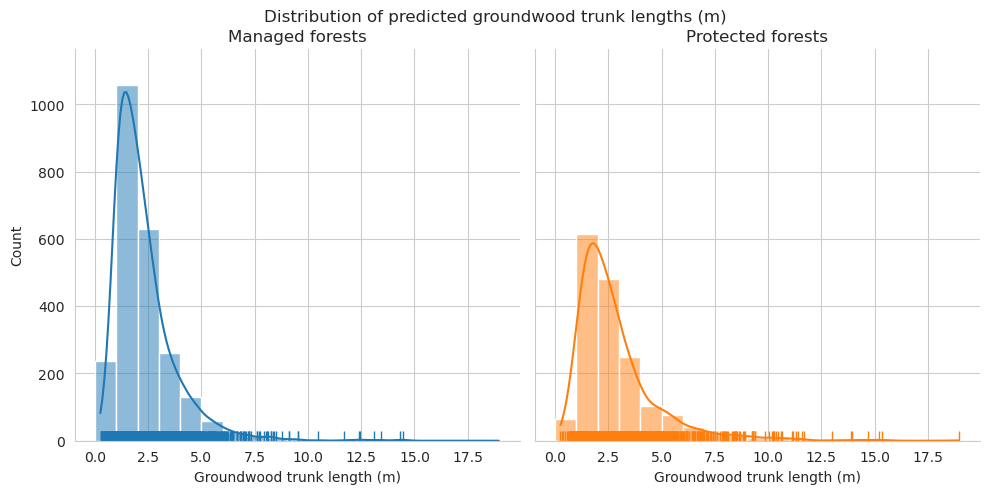

In [ ]:
#| echo: false
g = sns.displot(data=evo_preds[evo_preds.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(evo_preds.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

The clearest difference between these distributions are that on average the predictions are shorter than annotations.

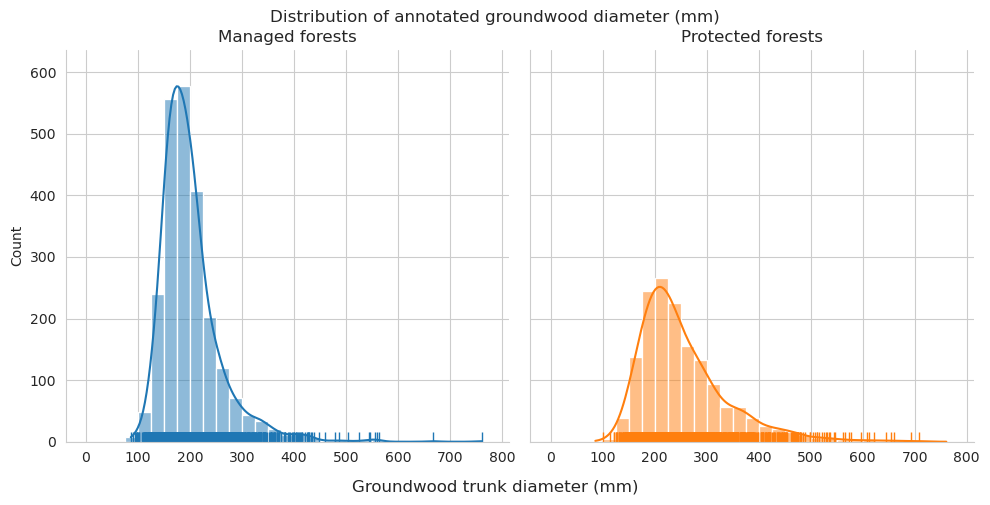

In [ ]:
#| echo: false
g = sns.displot(data=evo_anns[(evo_anns.label=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(evo_anns[(evo_anns.label=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

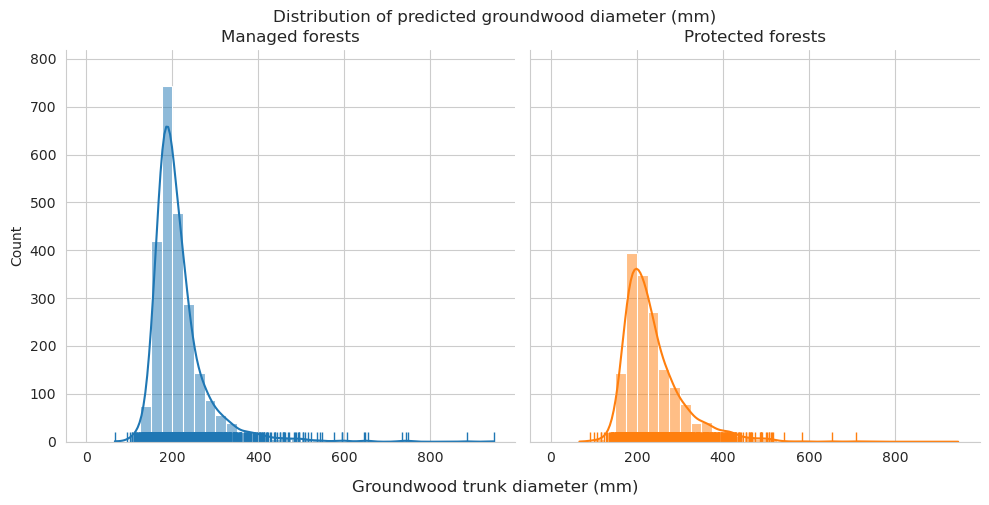

In [ ]:
#| echo: false
g = sns.displot(data=evo_preds[(evo_preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(evo_preds[(evo_preds.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

Then statistics for groundwood diameter and length. First annotations.

In [ ]:
evo_anns[evo_anns.label=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                       margins=True, aggfunc=['mean', 'min', 'max'])

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             200.474161    3.113435   85.977992    0.605847  760.781151   
1             254.250328    3.914179  101.096059    0.575351  709.170305   
All           221.709909    3.429642   85.977992    0.575351  760.781151   

                          
             tree_length  
conservation              
0              24.479043  
1              22.625422  
All            24.479043

Then predictions. On average, predictions are both shorter and thinner than annotations.

In [ ]:
evo_preds[evo_preds.layer=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                           margins=True, aggfunc=['mean', 'min', 'max'])

mean                    min                     max  \
                    diam tree_length       diam tree_length        diam   
conservation                                                              
0             215.721066    2.285198  66.289676    0.281653  946.777021   
1             237.056243    2.832194  90.435975    0.251623  710.128841   
All           224.466939    2.509427  66.289676    0.251623  946.777021   

                          
             tree_length  
conservation              
0              14.455624  
1              18.956571  
All            18.956571

Check area covered by standing deadwood canopies. First annotations.

In [ ]:
evo_anns['area_m2'] = evo_anns.geometry.area
evo_preds['area_m2'] = evo_preds.geometry.area
evo_anns[evo_anns.label=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                                    aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,3.142462,1212.990283
1,5.811285,6003.057735
All,5.085305,7216.048018


Then predictions. On average predicted canopies are larger than annotated.

In [ ]:
evo_preds[evo_preds.layer=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                                      aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,3.750448,1436.421535
1,5.776561,4661.684400
All,5.124459,6098.105935


In [ ]:
evo_anns['v_ddw'] = evo_anns.geometry.apply(cut_cone_volume)
evo_preds['v_ddw'] = evo_preds.geometry.apply(cut_cone_volume)

evo_vplot_area = evo_grid.area.sum()
evo_cons_area = cons_evo.area.sum()
evo_man_area = evo_vplot_area - evo_cons_area
evo_man_ha = evo_man_area / 10000
evo_cons_ha = evo_cons_area / 10000

evo_ann_est_v_man = evo_anns[(evo_anns.label=='groundwood')&(evo_anns.conservation==0)].v_ddw.sum()/evo_man_ha
evo_ann_est_v_cons = evo_anns[(evo_anns.label=='groundwood')&(evo_anns.conservation==1)].v_ddw.sum()/evo_cons_ha
evo_ann_est_v = evo_anns[(evo_anns.label=='groundwood')].v_ddw.sum()/(evo_vplot_area/10000)

evo_pred_est_v_man = evo_preds[(evo_preds.layer=='groundwood')&(evo_preds.conservation==0)].v_ddw.sum()/evo_man_ha
evo_pred_est_v_cons = evo_preds[(evo_preds.layer=='groundwood')&(evo_preds.conservation==1)].v_ddw.sum()/evo_cons_ha
evo_pred_est_v = evo_preds[(evo_preds.layer=='groundwood')].v_ddw.sum()/(evo_vplot_area/10000)

In [ ]:
print(f'Estimated groundwood volume in managed forests, based on annotations: {evo_ann_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on annotations: {evo_ann_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on annotations: {evo_ann_est_v:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on annotations: 7.08 ha/m³
Estimated groundwood volume in conserved forests, based on annotations: 13.97 ha/m³
Estimated groundwood volume in both types, based on annotations: 9.90 ha/m³


In [ ]:
print(f'Estimated groundwood volume in managed forests, based on predictions: {evo_pred_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on predictions: {evo_pred_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on predictions: {evo_pred_est_v:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on predictions: 7.03 ha/m³
Estimated groundwood volume in conserved forests, based on predictions: 10.17 ha/m³
Estimated groundwood volume in both types, based on predictions: 8.31 ha/m³


## Predictions vs field data, plot-wise

Add canopy density based on LiDAR derived canopy height model. The density is the percentage of field plot area with height above 2 meters.

In [ ]:
pcts = []

with rio.open('../../data/raw/sudenpesankangas/full_mosaics/sudenpesankangas_chm.tif') as src:
    for row in evo_plots.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])

evo_plots['canopy_cover_pct'] = pcts

pd.pivot_table(data=evo_plots, index=['conservation'], values=['canopy_cover_pct'],
               aggfunc=['min', 'max', 'mean', 'std', 'count'], margins=True)

,min,max,mean,std,count
,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct
conservation,,,,,
0,0.237288,0.989960,0.782452,0.200439,42
1,0.678000,0.991992,0.869878,0.085901,29
All,0.237288,0.991992,0.818162,0.168393,71


Count the number of deadwood instances similarly as for Hiidenportti data and plot the relationship between them.

In [ ]:
evo_plots['n_dw_ann'] = evo_plots.apply(lambda row: evo_anns.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns.plot_id.unique() else 0, axis=1)
evo_plots['n_ddw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label=='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label=='groundwood'].plot_id.unique() else 0, axis=1)
evo_plots['n_udw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label!='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label!='groundwood'].plot_id.unique() else 0, axis=1)

evo_plots['n_dw_plot'] = np.round((evo_plots['n_dw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_ddw_plot'] = np.round((evo_plots['n_ddw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_udw_plot'] = evo_plots.n_dw_plot - evo_plots.n_ddw_plot
evo_plots['conservation'] = evo_plots.apply(lambda row: 1 if any(cons_evo.geometry.contains(row.geometry))
                                                        else 0, axis=1)

evo_plots['n_dw_pred'] = evo_plots.apply(lambda row: evo_preds.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds.plot_id.unique() else 0, axis=1)
evo_plots['n_ddw_pred'] = evo_plots.apply(lambda row: evo_preds[evo_preds.layer=='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds[evo_preds.layer=='groundwood'].plot_id.unique() else 0, axis=1)
evo_plots['n_udw_pred'] = evo_plots.apply(lambda row: evo_preds[evo_preds.layer!='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds[evo_preds.layer!='groundwood'].plot_id.unique() else 0, axis=1)



Compare the number of annotations, predictions and field measurements within plots.

In [ ]:
evo_plots.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 'n_ddw_ann', 'n_udw_ann', 
                                                    'n_ddw_pred', 'n_udw_pred'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_ddw_pred,n_udw_ann,n_udw_plot,n_udw_pred
conservation,,,,,,
0,65,14,59,14,68,11
1,22,29,30,29,92,21
All,87,43,89,43,160,32


Plot the relationship between annotated and field data.

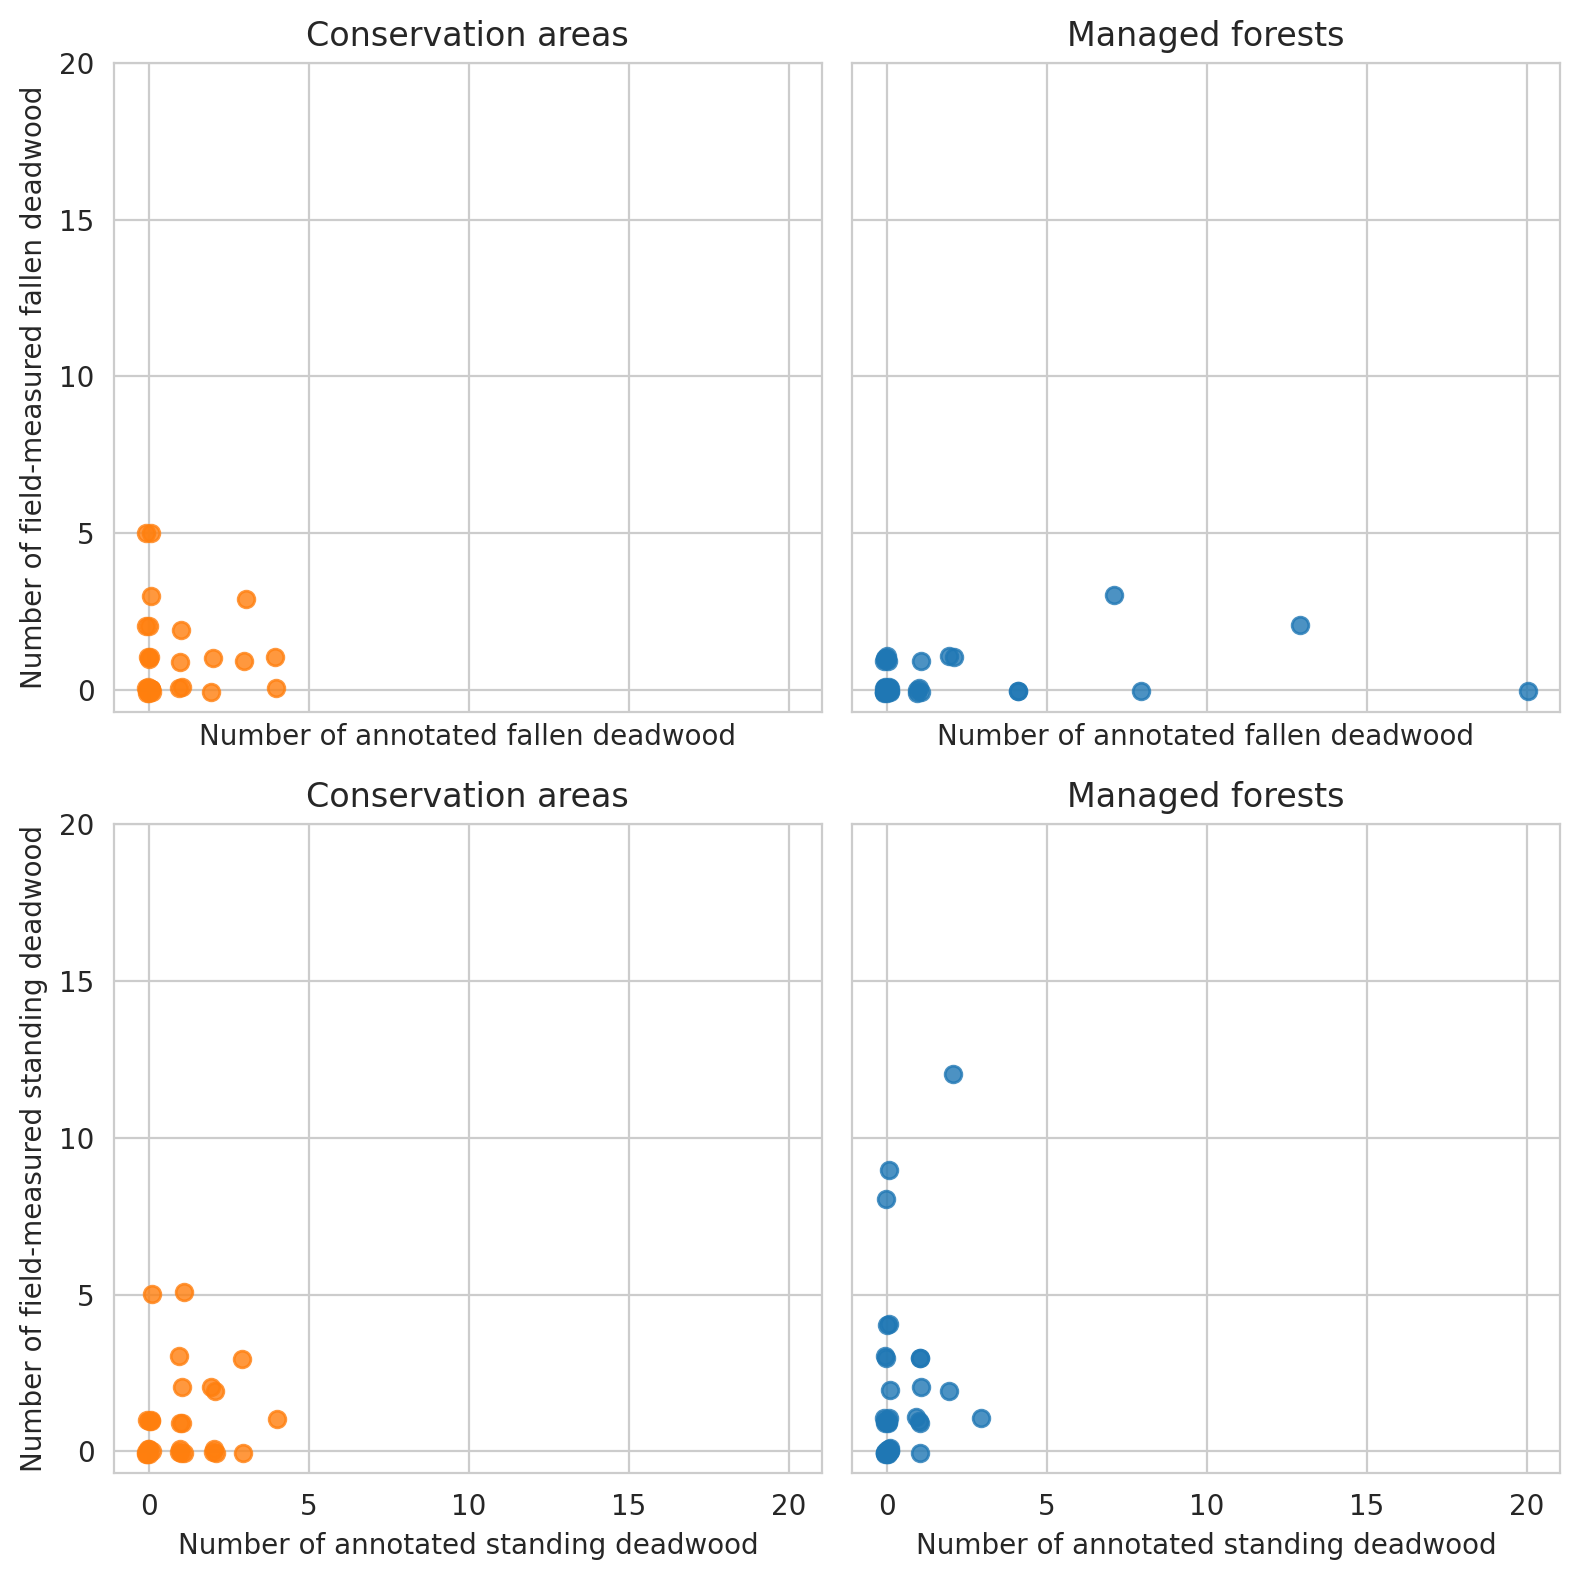

In [ ]:
#| echo: false

fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_ddw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
plt.tight_layout()
plt.show()

Same for field data and predictions.

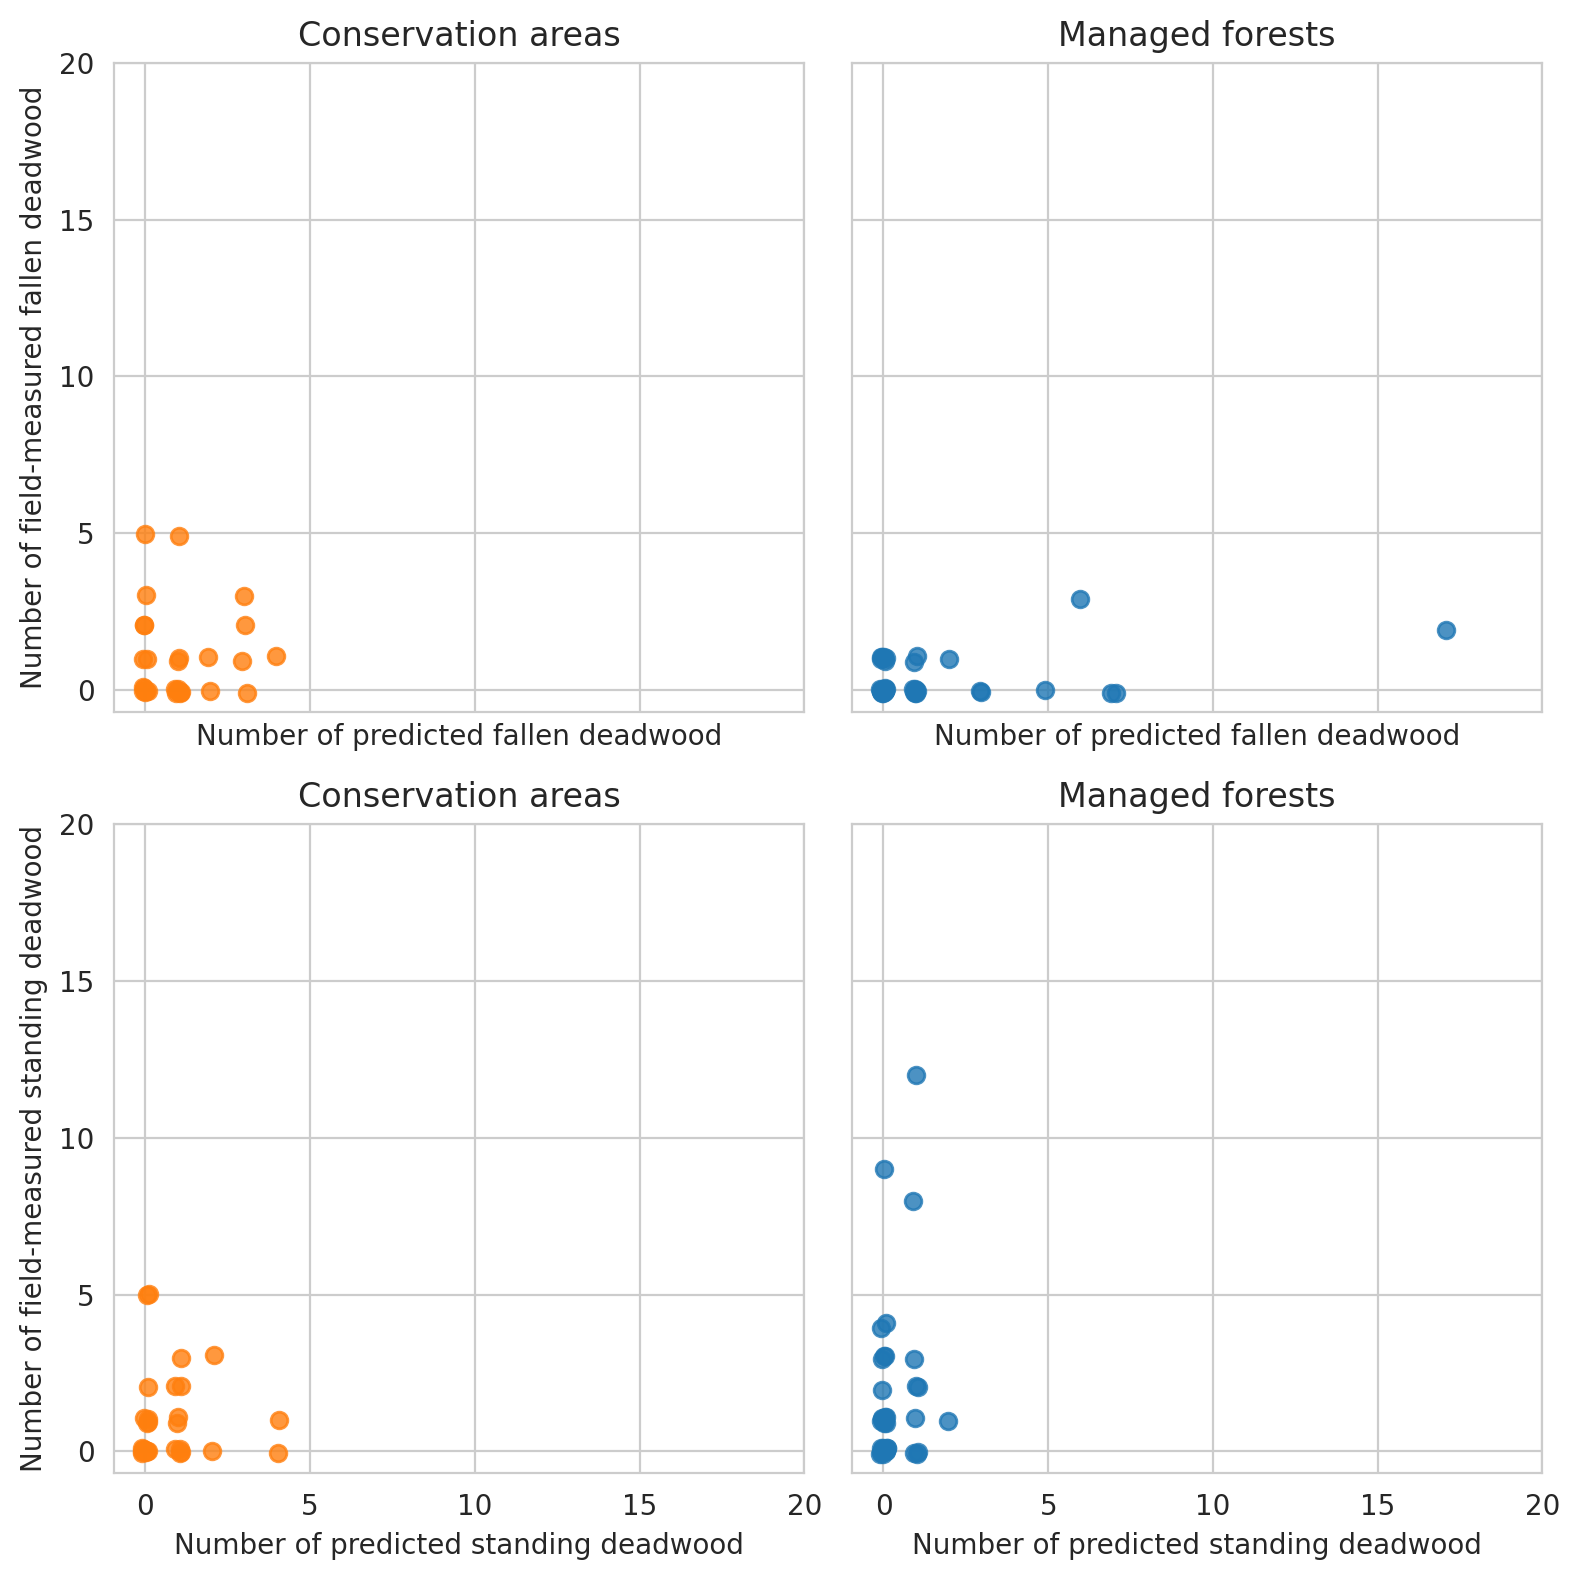

In [ ]:
#| echo: false

fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xticks(range(0,21,5))
ax[0,0].set_xticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of predicted fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xticks(range(0,21,5))
ax[0,1].set_xticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of predicted fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_udw_pred', y='n_ddw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of predicted standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
ax[1,0].set_xticks(range(0,21,5))
ax[1,0].set_xticklabels(range(0,21,5))
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of predicted standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
ax[1,1].set_xticks(range(0,21,5))
ax[1,1].set_xticklabels(range(0,21,5))
plt.tight_layout()
plt.show()

Relationship between canopy cover and deadwood.

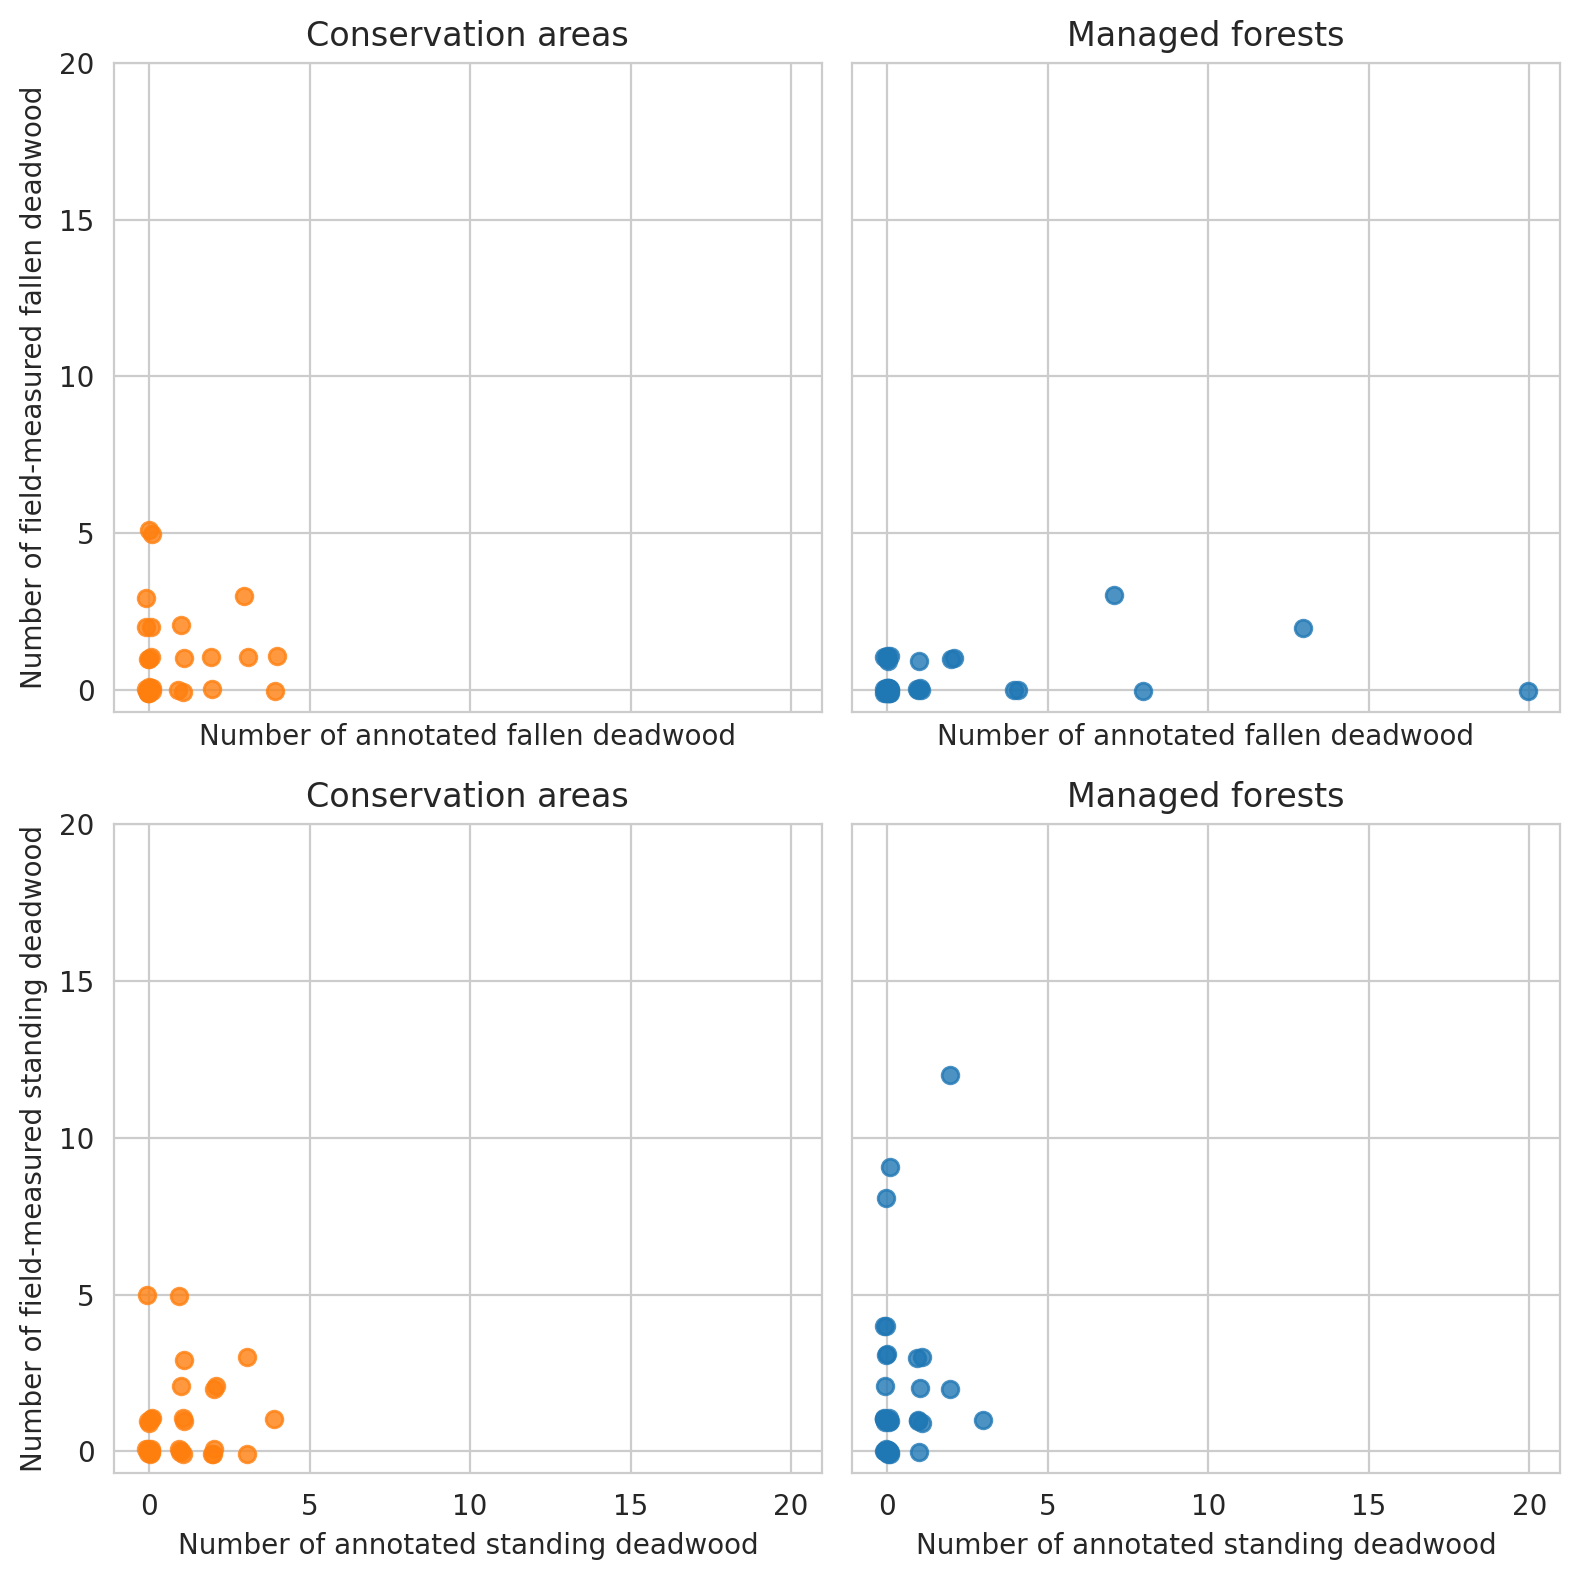

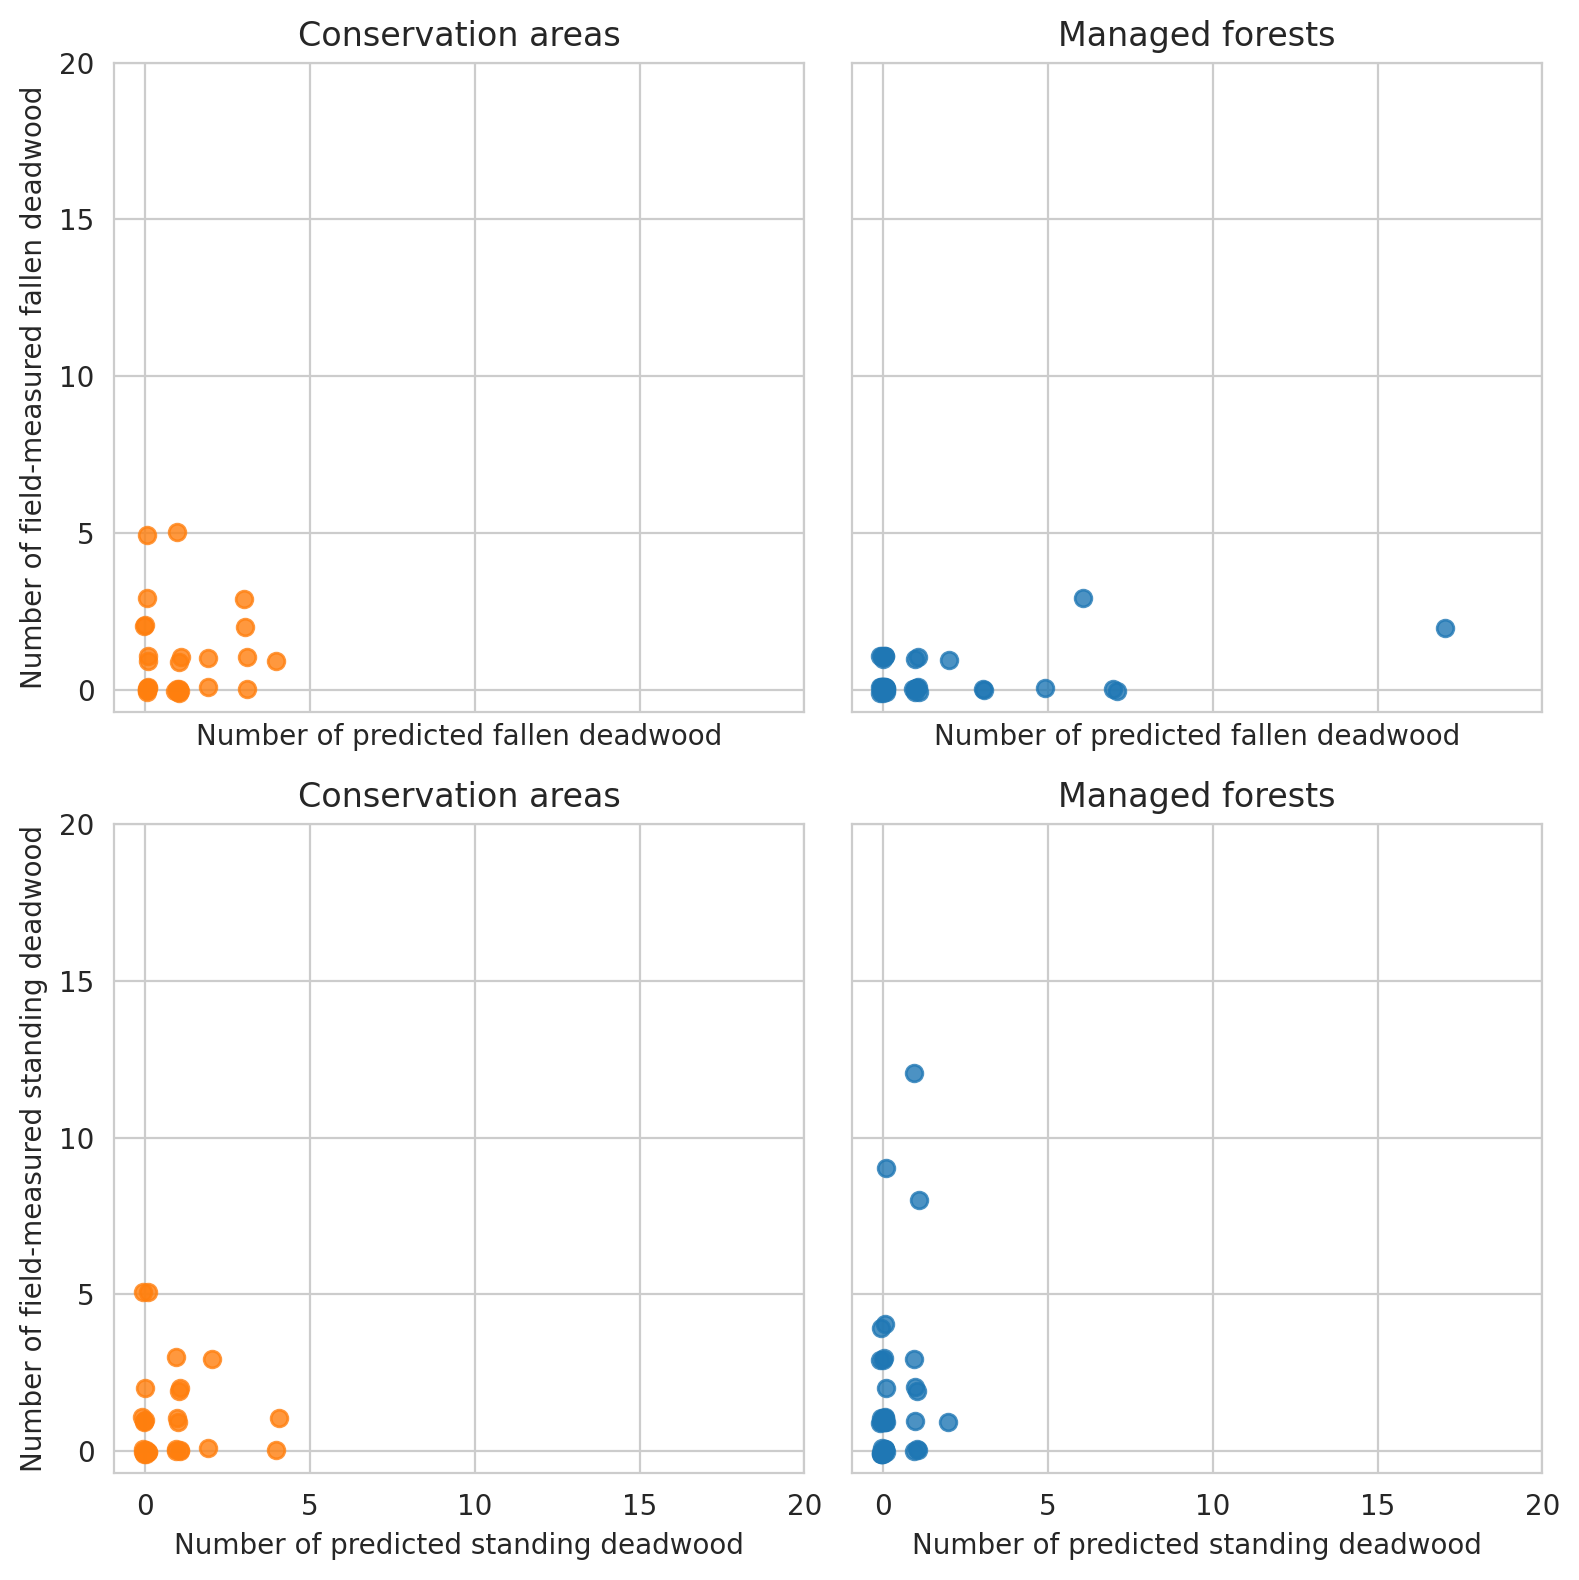

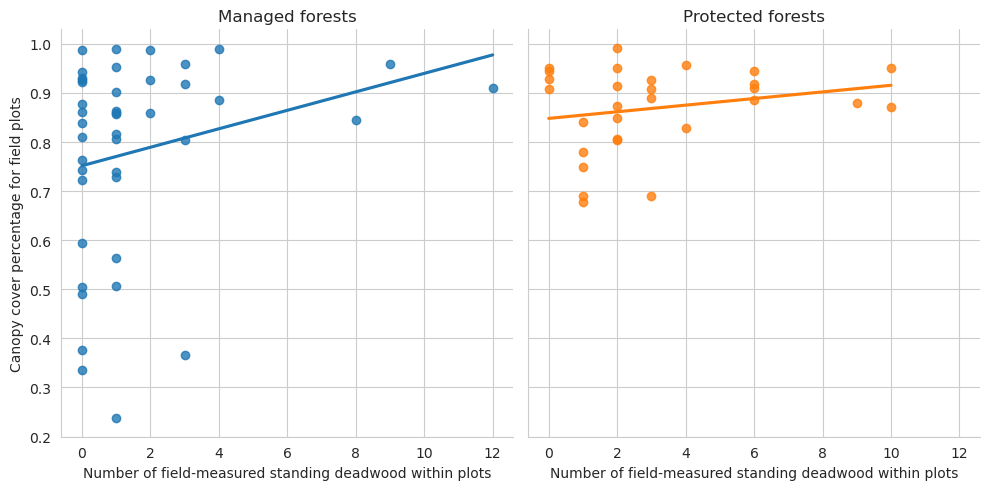

In [ ]:
g = sns.lmplot(data=evo_plots, x='n_udw_plot', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of field-measured standing deadwood within plots')
plt.show()

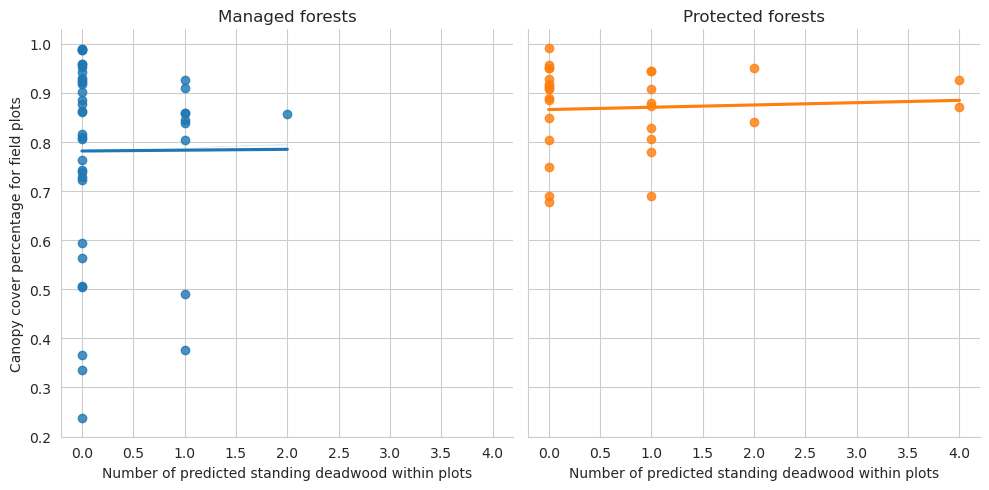

In [ ]:
g = sns.lmplot(data=evo_plots, x='n_udw_pred', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of predicted standing deadwood within plots')
plt.show()

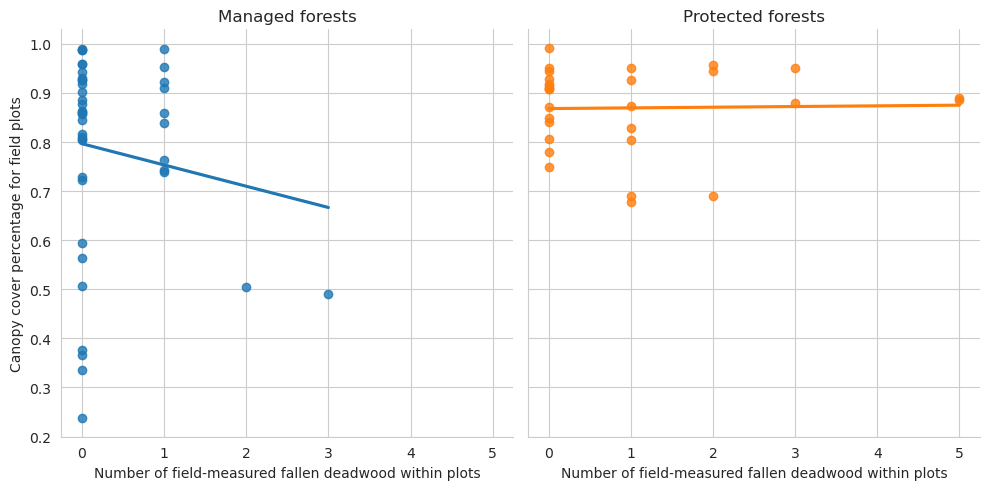

In [ ]:
g = sns.lmplot(data=evo_plots, x='n_ddw_plot', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of field-measured fallen deadwood within plots')
plt.show()

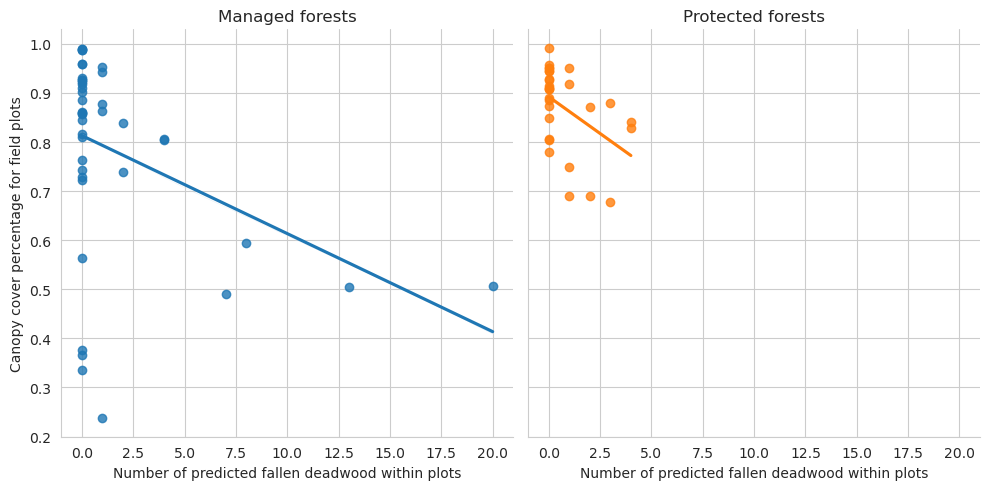

In [ ]:
g = sns.lmplot(data=evo_plots, x='n_ddw_ann', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of predicted fallen deadwood within plots')
plt.show()

As Evo data doesn't have field-measured deadwood lengths, we can't plot that relationship. We can, however, plot the DBH distributions, even though Evo dataset only has around 50 downed deadwood with dbh measured.

In [ ]:
evo_field_data = evo_field_data[evo_field_data.plotid.isin(evo_plots.id.unique())]

evo_field_data['conservation'] = evo_field_data.apply(lambda row: evo_plots[evo_plots.id == row.plotid].conservation.unique()[0], axis=1)

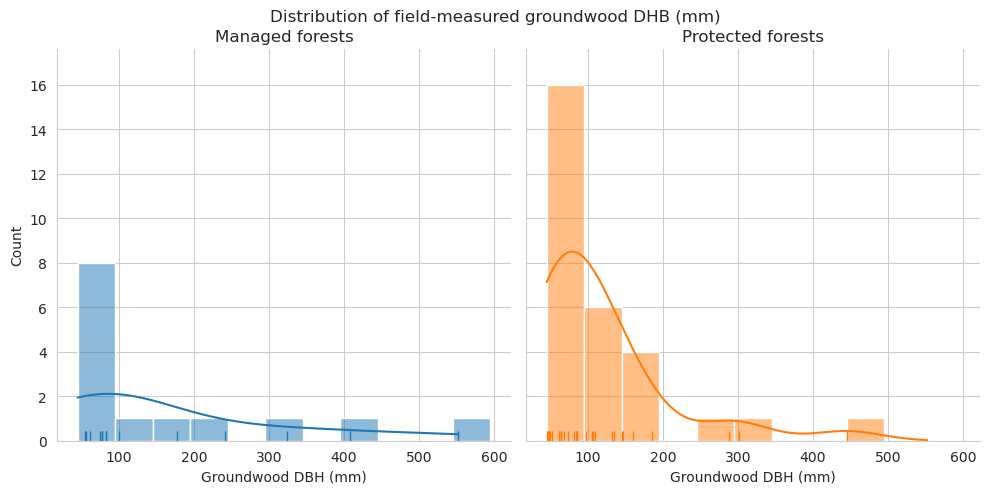

In [ ]:
#| echo: false

g = sns.displot(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)], 
                x='lapimitta_mm', hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=50) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood DBH (mm)')
plt.show()

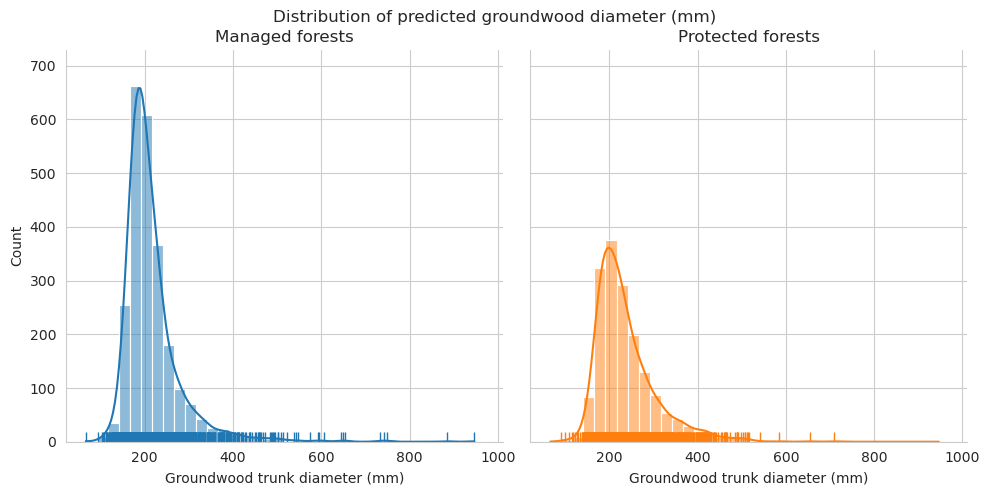

In [ ]:
#| echo: false

evo_preds_in_plots['diam'] = evo_preds_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=evo_preds[(evo_preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, binwidth=25) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk diameter (mm)')
plt.show()

`est_pituus_m` is the estimated lenght of the deadwood, based on DBH (`lapimitta_mm`) and growth formulae, so that is really inaccurate.

In [ ]:
pd.pivot_table(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)],
               index=['conservation'], values=['est_pituus_m', 'lapimitta_mm'],
               aggfunc=['mean', 'min', 'max', 'count'], margins=True)

mean                       min                       max  \
             est_pituus_m lapimitta_mm est_pituus_m lapimitta_mm est_pituus_m   
conservation                                                                    
0               13.609571   169.357143        5.934           55       34.211   
1               11.905690   115.896552        5.446           45       28.101   
All             12.460442   133.302326        5.446           45       34.211   

                                 count               
             lapimitta_mm est_pituus_m lapimitta_mm  
conservation                                         
0                     552           14           14  
1                     445           29           29  
All                   552           43           43

Length and diameter statistics for predictions.

In [ ]:
evo_preds_in_plots['tree_length'] = evo_preds_in_plots.geometry.apply(get_len)

pd.pivot_table(data=evo_preds_in_plots[evo_preds_in_plots.label==2], index=['conservation'], 
               values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             226.345153    2.369562  152.538266    0.759256  502.915702   
1             229.329760    2.509369  158.456434    0.974683  356.577743   
All           227.351200    2.416688  152.538266    0.759256  502.915702   

                          
             tree_length  
conservation              
0               9.128894  
1               6.525554  
All             9.128894

Estimated volume statistics for Evo area. First based on field data.

In [ ]:
evo_preds_in_plots['v_ddw'] = evo_preds_in_plots.geometry.apply(cut_cone_volume)
evo_plots['v_ddw_pred'] = evo_plots.apply(lambda row: evo_preds_in_plots[(evo_preds_in_plots.plot_id == row.id) &
                                                              (evo_preds_in_plots.layer == 'groundwood')
                                                              ].v_ddw.sum()
                                              , axis=1)

evo_plots['v_ddw_pred_ha'] = (10000 * evo_plots.v_ddw_pred) / (np.pi * 9**2)
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,0.0,123.004587,5.522673,0.0,23.497052,42
1,0.0,98.258093,6.338610,0.0,18.873961,29
All,0.0,123.004587,5.855943,0.0,21.587804,71


Then based on predictions.

In [ ]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw_pred_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha
conservation,,,,,,
0,0.0,102.564677,7.270016,0.000000,18.221962,42
1,0.0,32.592807,5.409204,2.206135,8.067147,29
All,0.0,102.564677,6.509966,0.000000,14.878194,71
